In [11]:
import pandas as pd
import numpy as np 
import os
import functools
import tempfile


from urllib.request import urlopen,urlretrieve
from PIL import Image
from sklearn.utils import shuffle
import cv2
#import tensorflow as tf
#from tensorflow import keras
import keras
from keras.utils import to_categorical
from keras.models import load_model
from sklearn.datasets import load_files   
from keras.utils import np_utils
from keras import applications
from keras.preprocessing.image import ImageDataGenerator 
from keras import optimizers
from keras.models import Sequential,Model,load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D
from keras.callbacks import TensorBoard,ReduceLROnPlateau,ModelCheckpoint

from keras.optimizers import SGD, Adam
from matplotlib import pyplot as plt
plt.style.use('default')

In [2]:
def data_preprocess(X_orig, Y_orig):

    X = X_orig/255.  #X_test = X_test_orig/255.
# Convert training and test labels to one hot matrices
    Y = Y_orig  #Y_test = convert_to_one_hot(Y_test_orig, 6).T
    shuffle = np.random.permutation(np.arange(X.shape[0]))
    X, Y = X[shuffle], Y[shuffle]
    
    i = int(0.8*X.shape[0])
    j = int(0.9*X.shape[0])


    X_train, Y_train = X[:i], Y[:i]  # 8446*80% = 6758
    X_test, Y_test = X[i:j], Y[i:j]  # 10% test
    X_dev, Y_dev = X[j:], Y[j:]  # 10% dev

    print ("X_train shape: " + str(X_train.shape))
    print ("Y_train shape: " + str(Y_train.shape))
    print ("X_test shape: " + str(X_test.shape))
    print ("Y_test shape: " + str(Y_test.shape))
    print ("X_dev shape: " + str(X_dev.shape))
    print ("Y_dev shape: " + str(Y_dev.shape))

    return  X_train, Y_train, X_test, Y_test, X_dev, Y_dev 



def plot_learning_curves(history, log=True):
    '''
    Plot the model accuracy and loss learning curves for both the train and validation 
    data sets.
    '''
    fig, ax = plt.subplots(1, 3, figsize=(30,8))
    acy = history.history['categorical_accuracy']
    val_acy = history.history['val_categorical_accuracy']
    t5acy = history.history['top5_acc']
    val_t5acy = history.history['val_top5_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    
    acy_ylabel = 'accuracy'
    t5acy_ylabel = 'top5 acc'
    loss_ylabel = 'loss'
    
    
    if log:
        acy = np.log(acy)
        val_acy = np.log(val_acy)
        loss = np.log(loss)
        val_loss = np.log(val_loss)
        t5acy = np.log(t5acy)
        val_t5acy = np.log(val_t5acy)
        
        acy_ylabel = 'log accuracy'
        loss_ylabel = 'log loss'
        t5acy_ylabel = 'log top5 acc'


  # Plot the accuracy 
    ax[0].plot(acy)
    ax[0].plot(val_acy)
    ax[0].set_title('Model performance')
    ax[0].set_ylabel(acy_ylabel)
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['train', 'val'], loc='upper right')

  # Plot the loss
    ax[1].plot(loss)
    ax[1].plot(val_loss)
    ax[1].set_title('Model loss')
    ax[1].set_ylabel(loss_ylabel)
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['train', 'val'], loc='upper right')
    
    # Plot the top5 accuracy 
    ax[2].plot(t5acy)
    ax[2].plot(val_t5acy)
    ax[2].set_title('Model performance')
    ax[2].set_ylabel(t5acy_ylabel)
    ax[2].set_xlabel('Epoch')
    ax[2].legend(['train', 'val'], loc='upper right')
    
    plt.show()

In [3]:
def add_regularization(model, regularizer=keras.regularizers.l2(0.0001)):

    if not isinstance(regularizer, keras.regularizers.Regularizer):
        print("Regularizer must be a subclass of tf.keras.regularizers.Regularizer")
        return model

    for layer in model.layers:
        for attr in ['kernel_regularizer']:
            if hasattr(layer, attr):
                setattr(layer, attr, regularizer)

    # When we change the layers attributes, the change only happens in the model config file
    model_json = model.to_json()

    # Save the weights before reloading the model.
    tmp_weights_path = os.path.join(tempfile.gettempdir(), 'tmp_weights.h5')
    model.save_weights(tmp_weights_path)

    # load the model from the config
    model = keras.models.model_from_json(model_json)
    
    # Reload the model weights
    model.load_weights(tmp_weights_path, by_name=True)
    return model

## 1. Dataset train_data.npy (8446)

In [4]:
X_orig = np.load('train_data.npy')
Y_orig = to_categorical(np.load('train_labels.npy'))

In [5]:
X_train, Y_train, X_test, Y_test, X_dev, Y_dev = data_preprocess(X_orig, Y_orig)

X_train shape: (6756, 256, 256, 3)
Y_train shape: (6756, 50)
X_test shape: (845, 256, 256, 3)
Y_test shape: (845, 50)
X_dev shape: (845, 256, 256, 3)
Y_dev shape: (845, 50)


## 1b. Model Training

In [7]:
#RUN FOR RESNET
img_height,img_width = 256, 256 
num_classes = 50
base_model = applications.resnet50.ResNet50(weights= None, include_top=False, input_shape= (img_height,img_width,3))

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [10]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(num_classes, activation= 'softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)

In [11]:
# sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
adam = Adam(lr=0.0001)
model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
history = model.fit(X_train, Y_train, epochs = 50, batch_size = 64, validation_data=(X_dev, Y_dev))
model.save('model_1')

Train on 6756 samples, validate on 845 samples
Epoch 1/50
6756/6756 [==============================] - 116s 17ms/step - loss: 3.7883 - accuracy: 0.1245 - val_loss: 3.8432 - val_accuracy: 0.0840
Epoch 2/50
6756/6756 [==============================] - 109s 16ms/step - loss: 3.4347 - accuracy: 0.1718 - val_loss: 4.3780 - val_accuracy: 0.0320
Epoch 3/50
 128/6756 [..............................] - ETA: 1:43 - loss: 3.3742 - accuracy: 0.2188

KeyboardInterrupt: 

In [18]:
print(model.evaluate(X_dev, Y_dev))

845/845 [==============================] - 6s 7ms/step
[5.8713515778265055, 0.2355029582977295]


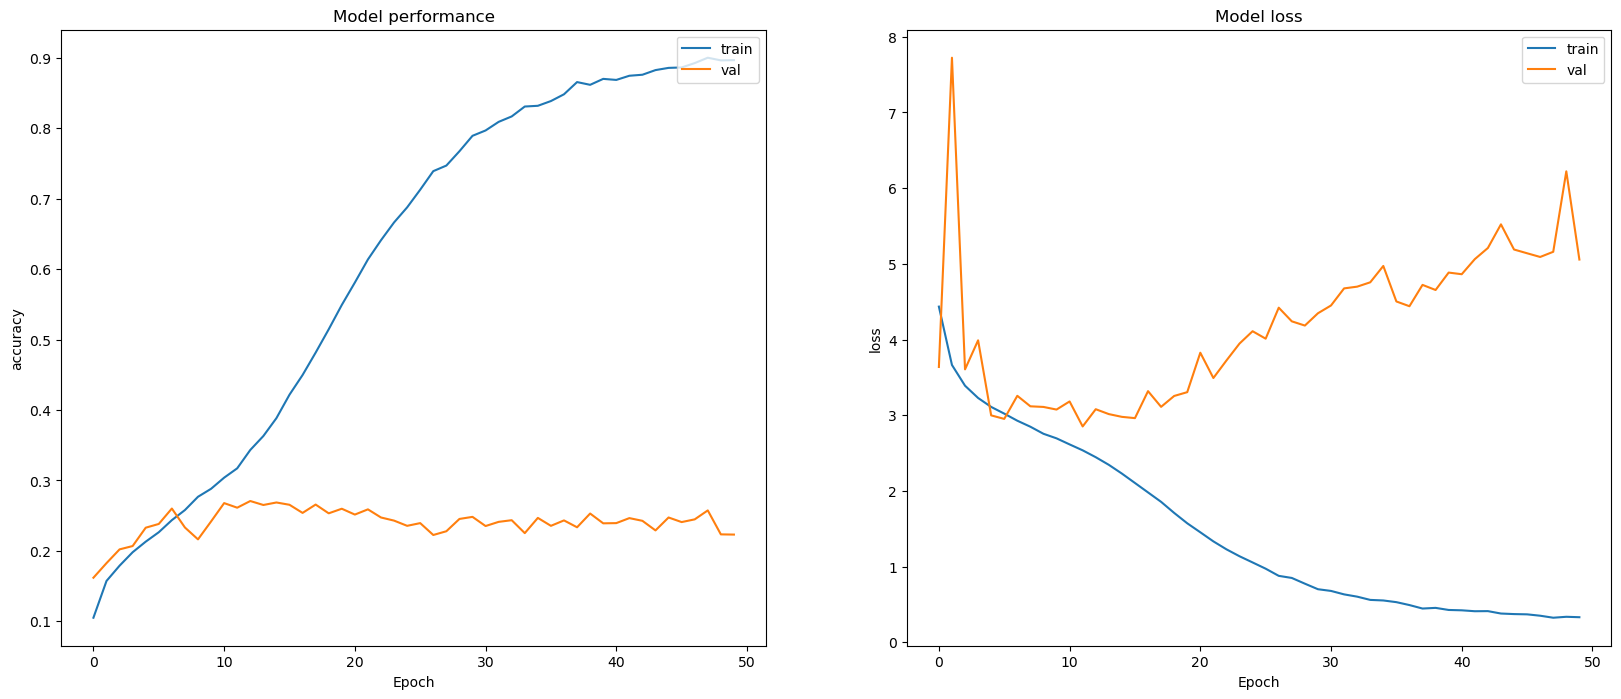

In [13]:
plot_learning_curves(history, False)

In [16]:
model1_temp = keras.models.load_model('model_1')

In [17]:
scores = model1_temp.evaluate(X_test, Y_test)

845/845 [==============================] - 4s 5ms/sample - loss: 5.8418 - accuracy: 0.2284


## 1b Resnet50

In [6]:
## model 
img_height,img_width = 256, 256
num_classes = 50 # 50 artists 
#If imagenet weights are being loaded, 
#input must have a static square shape (one of (128, 128), (160, 160), (192, 192), or (224, 224))
base_model = applications.resnet50.ResNet50(weights= None, include_top=False, input_shape= (img_height,img_width,3))

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [7]:
l2_model = add_regularization(base_model, regularizer=keras.regularizers.l2(0.01))
x = l2_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.9)(x)
predictions = Dense(num_classes, activation= 'softmax')(x)
model = Model(inputs = l2_model.input, outputs = predictions)

In [8]:
# sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
adam = Adam(lr=0.0001)
top5_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=5)
top5_acc.__name__ = 'top5_acc'
model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['categorical_accuracy', top5_acc])

Train on 6756 samples, validate on 845 samples
Epoch 1/100
6756/6756 [==============================] - 176s 26ms/step - loss: 98.5059 - categorical_accuracy: 0.2056 - top5_acc: 0.4919 - val_loss: 93.4956 - val_categorical_accuracy: 0.1953 - val_top5_acc: 0.5077
Epoch 16/100
6756/6756 [==============================] - 176s 26ms/step - loss: 89.3554 - categorical_accuracy: 0.1979 - top5_acc: 0.5016 - val_loss: 85.0171 - val_categorical_accuracy: 0.2095 - val_top5_acc: 0.5006
Epoch 17/100
6756/6756 [==============================] - 176s 26ms/step - loss: 81.2931 - categorical_accuracy: 0.2097 - top5_acc: 0.5099 - val_loss: 77.4084 - val_categorical_accuracy: 0.2154 - val_top5_acc: 0.5172
Epoch 18/100
6756/6756 [==============================] - 176s 26ms/step - loss: 74.3480 - categorical_accuracy: 0.2007 - top5_acc: 0.5036 - val_loss: 70.9042 - val_categorical_accuracy: 0.2296 - val_top5_acc: 0.4852
Epoch 19/100
6756/6756 [==============================] - 175s 26ms/step - loss: 68.09

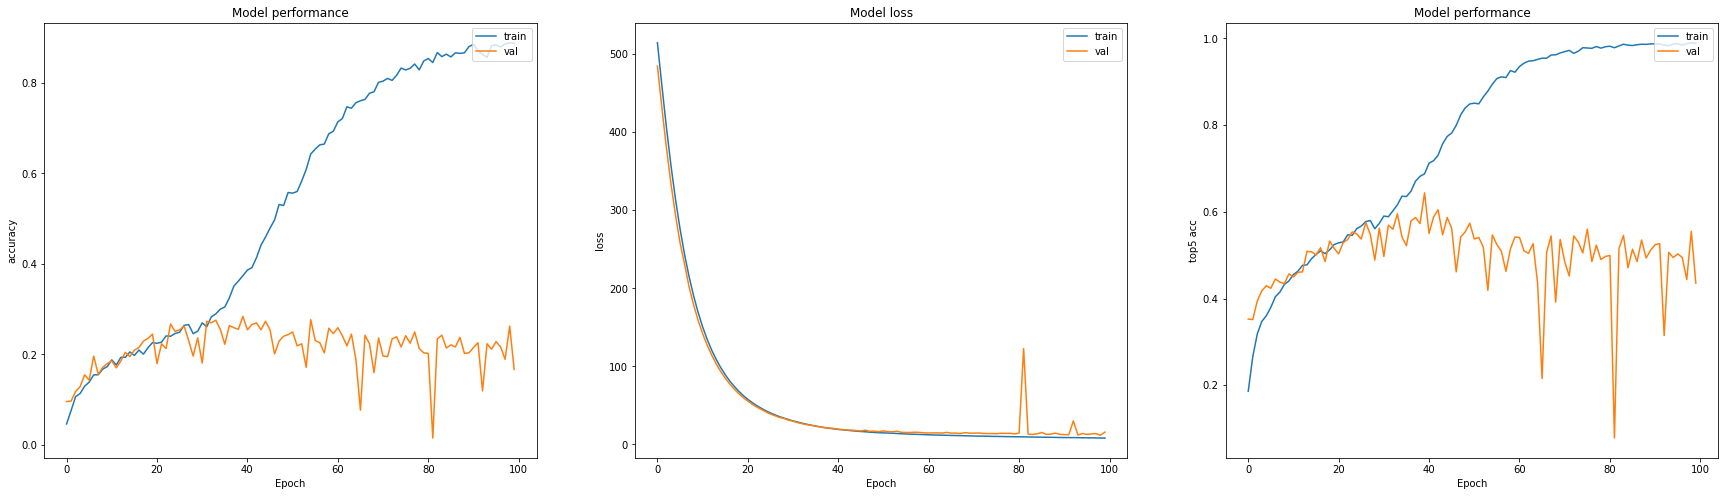

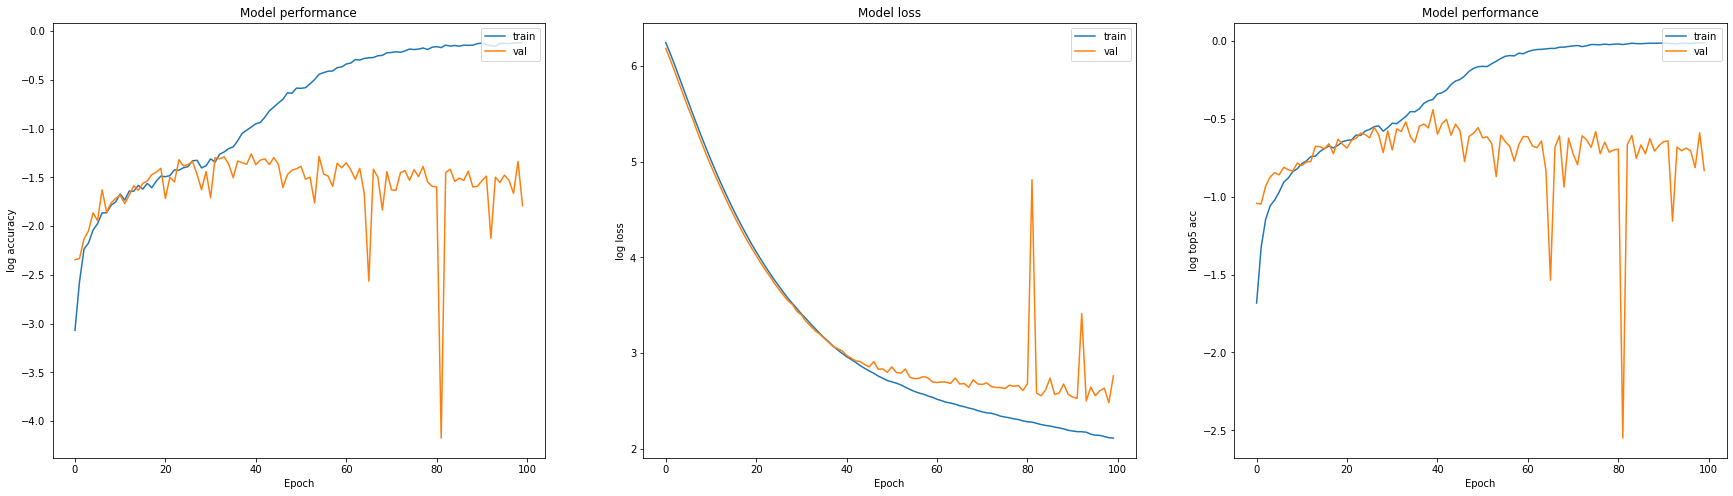

845/845 [==============================] - 7s 8ms/step
[15.796763349002635, 0.16686390340328217, 0.43550294637680054]


In [9]:
history = model.fit(X_train, Y_train, epochs = 100, batch_size = 64, validation_data=(X_dev, Y_dev))
model.save('model_1b')
plot_learning_curves(history, False)
plot_learning_curves(history, True)

#model_temp = keras.models.load_model('model_genre1e')
print(model.evaluate(X_dev, Y_dev))

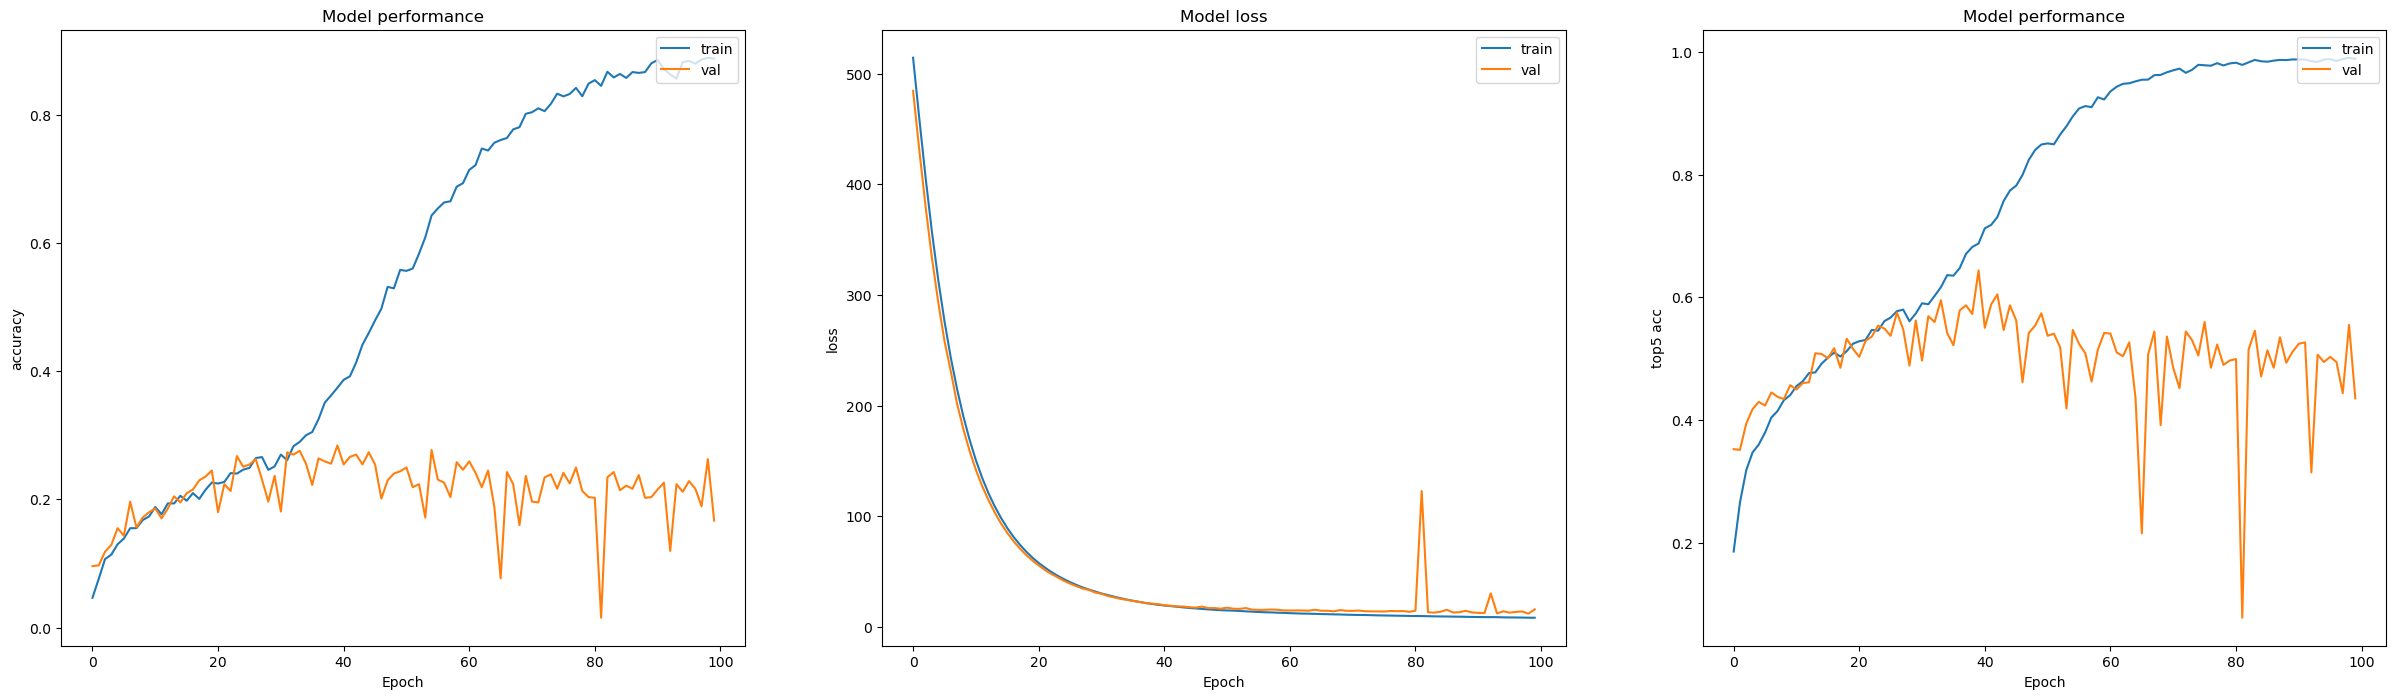

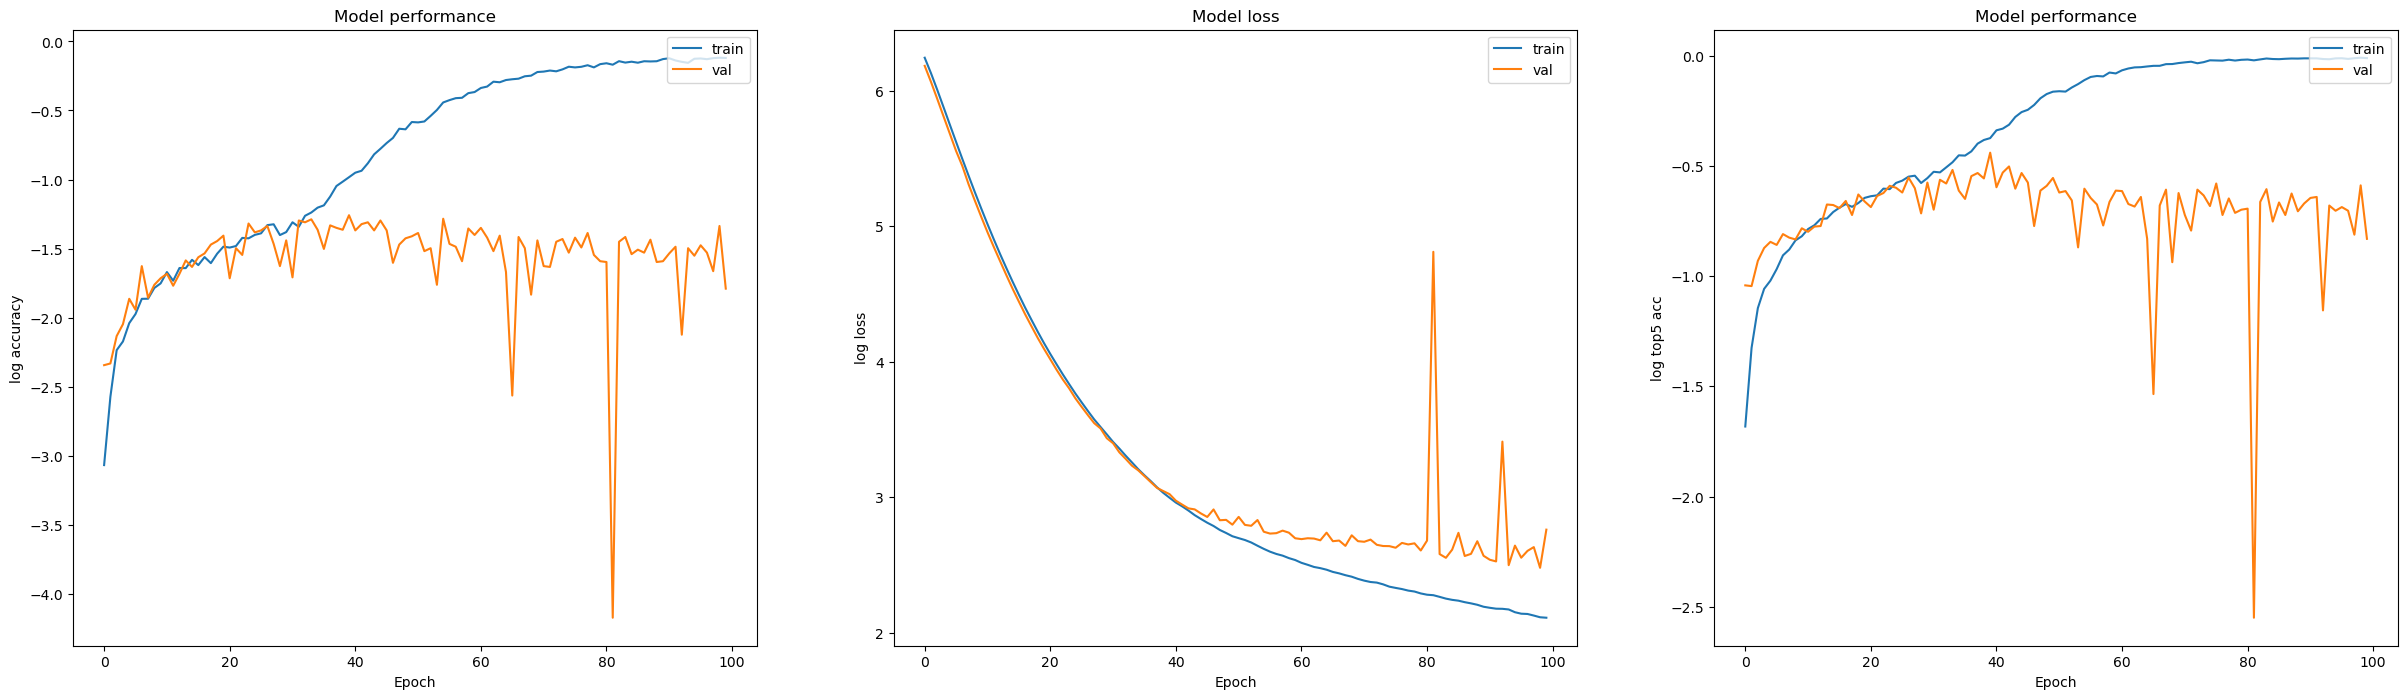

In [11]:
plot_learning_curves(history, False)
plot_learning_curves(history, True)

## 1c MobileNet

In [6]:
## model 
img_height,img_width = 256, 256
num_classes = 50 # 50 artists 
#If imagenet weights are being loaded, 
#input must have a static square shape (one of (128, 128), (160, 160), (192, 192), or (224, 224))
base_model = applications.MobileNet(weights= None, include_top=False, input_shape= (img_height,img_width,3))

In [7]:
l2_model = add_regularization(base_model, regularizer=keras.regularizers.l2(0.0001))
x = l2_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(num_classes, activation= 'softmax')(x)
model = Model(inputs = l2_model.input, outputs = predictions)

In [8]:
# sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
adam = Adam(lr=0.0001)
top5_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=5)
top5_acc.__name__ = 'top5_acc'
model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['categorical_accuracy', top5_acc])

Train on 6756 samples, validate on 845 samples
Epoch 1/100
6756/6756 [==============================] - 112s 17ms/step - loss: 4.4994 - categorical_accuracy: 0.0700 - top5_acc: 0.2432 - val_loss: 4.3216 - val_categorical_accuracy: 0.0876 - val_top5_acc: 0.2142
Epoch 2/100
6756/6756 [==============================] - 99s 15ms/step - loss: 4.2687 - categorical_accuracy: 0.0952 - top5_acc: 0.3188 - val_loss: 4.3825 - val_categorical_accuracy: 0.0876 - val_top5_acc: 0.2142
Epoch 3/100
6756/6756 [==============================] - 99s 15ms/step - loss: 4.1843 - categorical_accuracy: 0.1097 - top5_acc: 0.3382 - val_loss: 4.5180 - val_categorical_accuracy: 0.0876 - val_top5_acc: 0.2142
Epoch 4/100
6756/6756 [==============================] - 99s 15ms/step - loss: 4.1391 - categorical_accuracy: 0.1156 - top5_acc: 0.3656 - val_loss: 4.6188 - val_categorical_accuracy: 0.0876 - val_top5_acc: 0.2130
Epoch 5/100
6756/6756 [==============================] - 100s 15ms/step - loss: 4.0618 - categorical

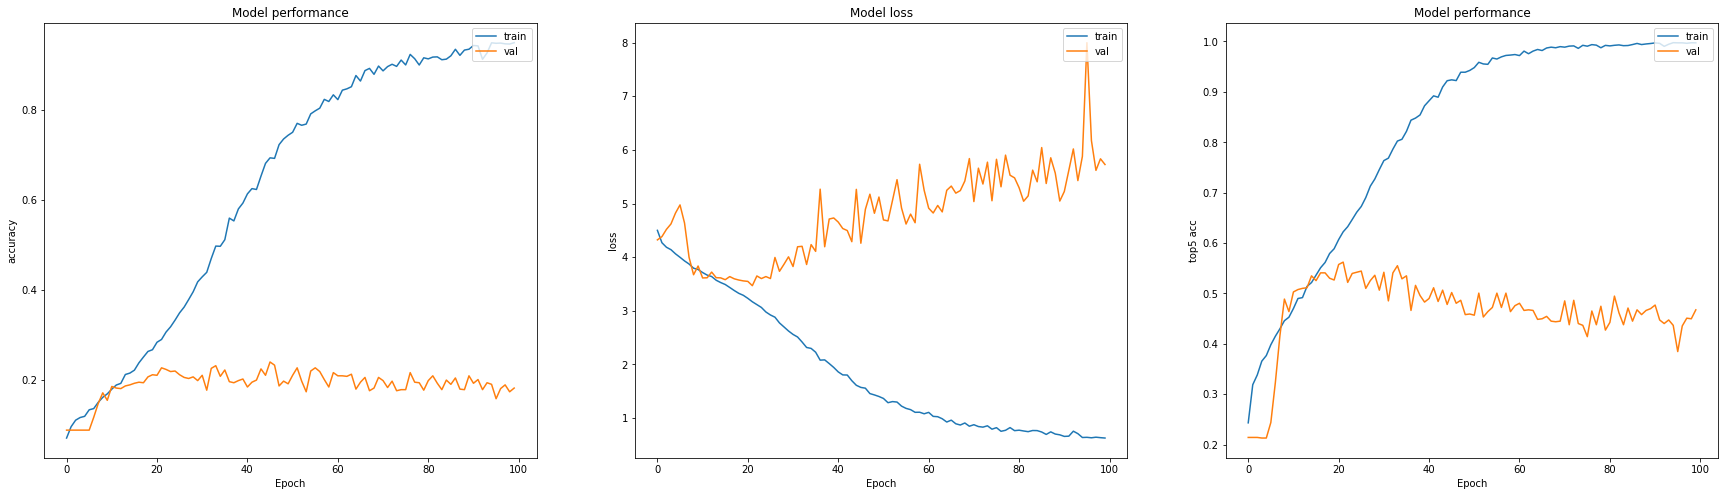

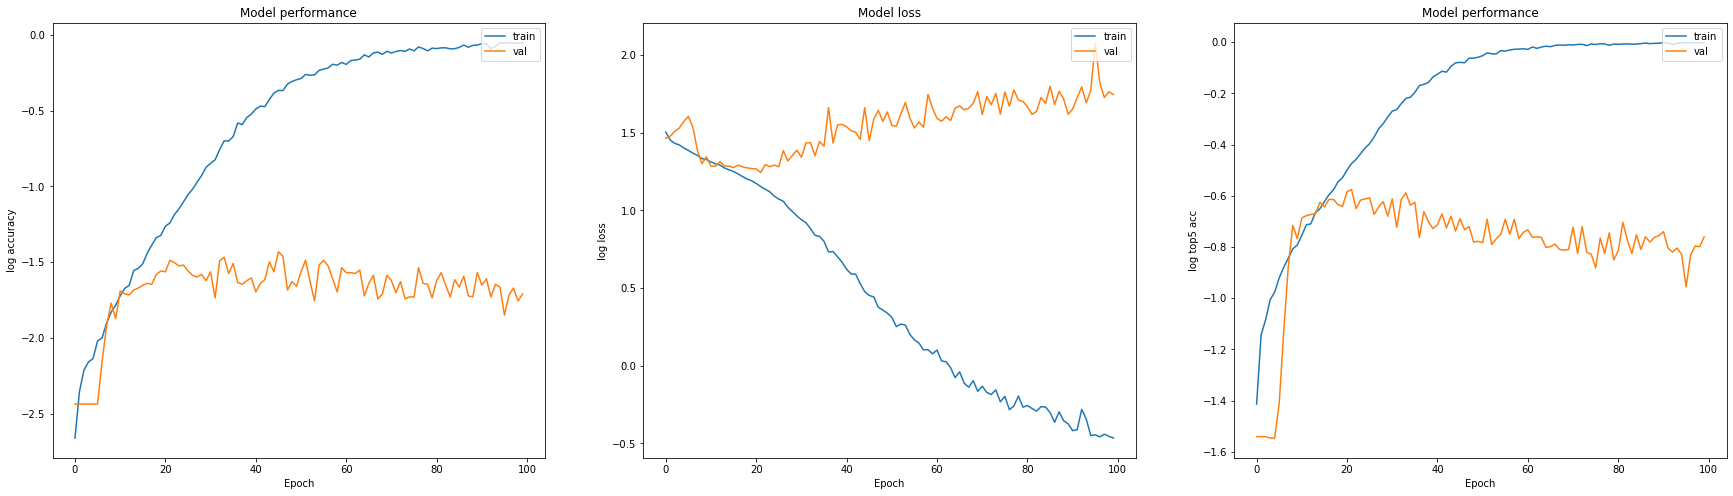

845/845 [==============================] - 3s 4ms/step
[5.726912588762814, 0.18106508255004883, 0.4674556255340576]


In [9]:
history = model.fit(X_train, Y_train, epochs = 100, batch_size = 64, validation_data=(X_dev, Y_dev))
model.save('model_1c')
plot_learning_curves(history, False)
plot_learning_curves(history, True)

#model_temp = keras.models.load_model('model_genre1e')
print(model.evaluate(X_dev, Y_dev))

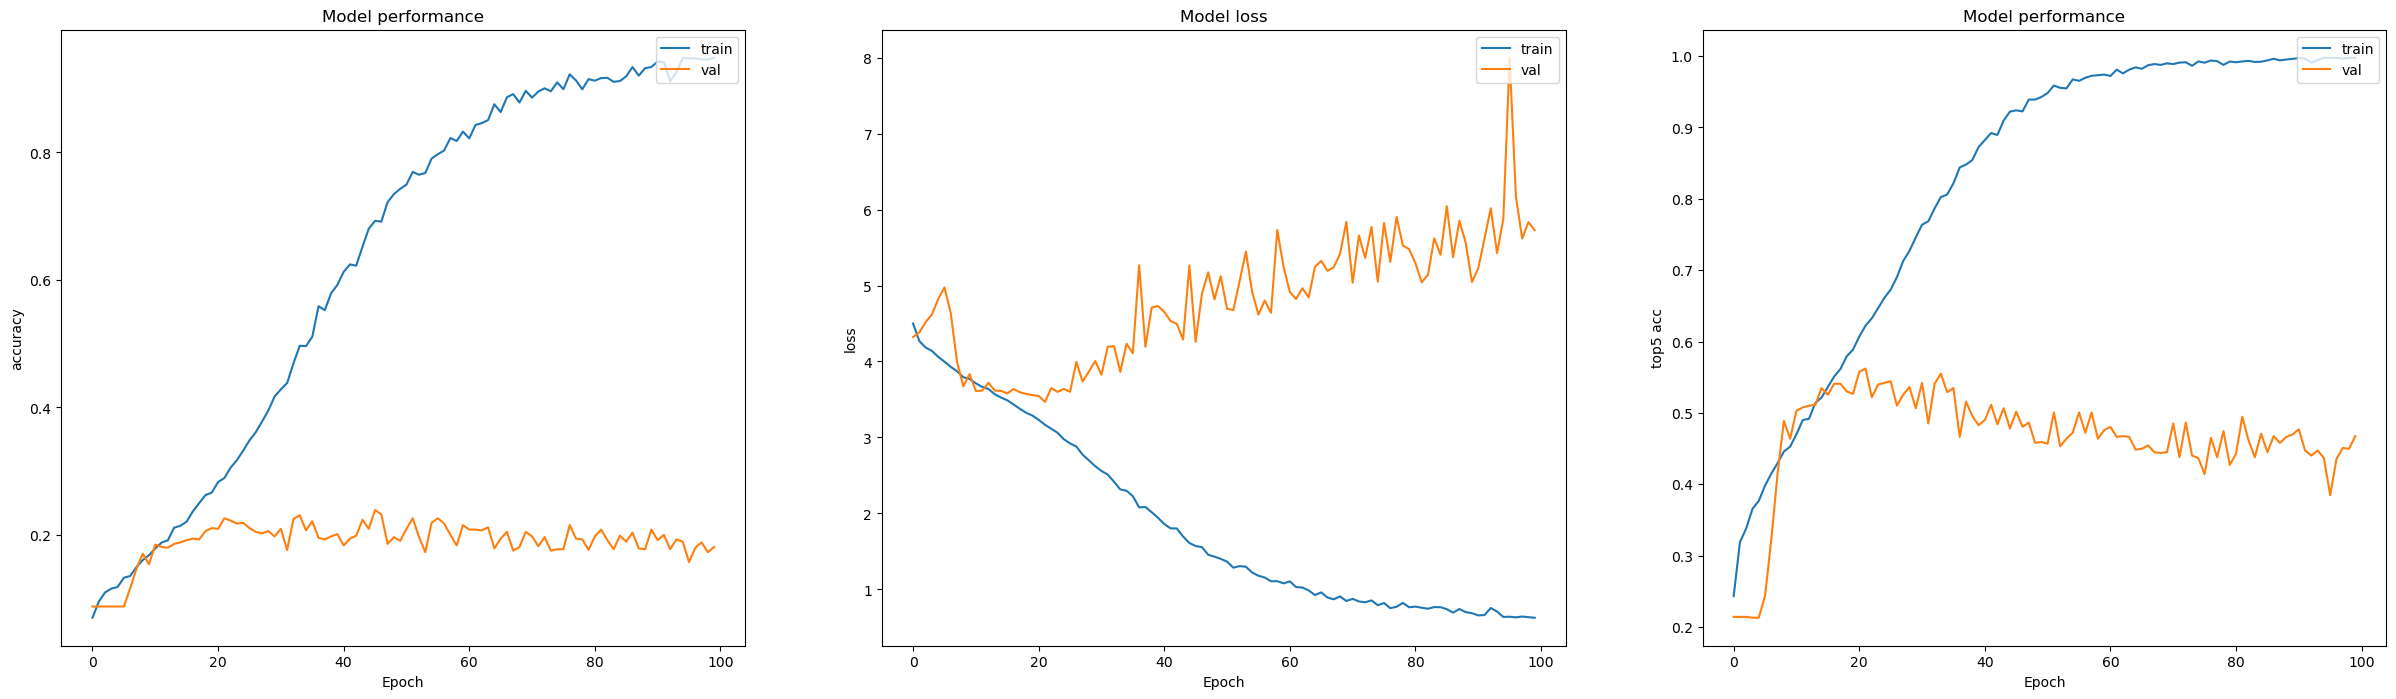

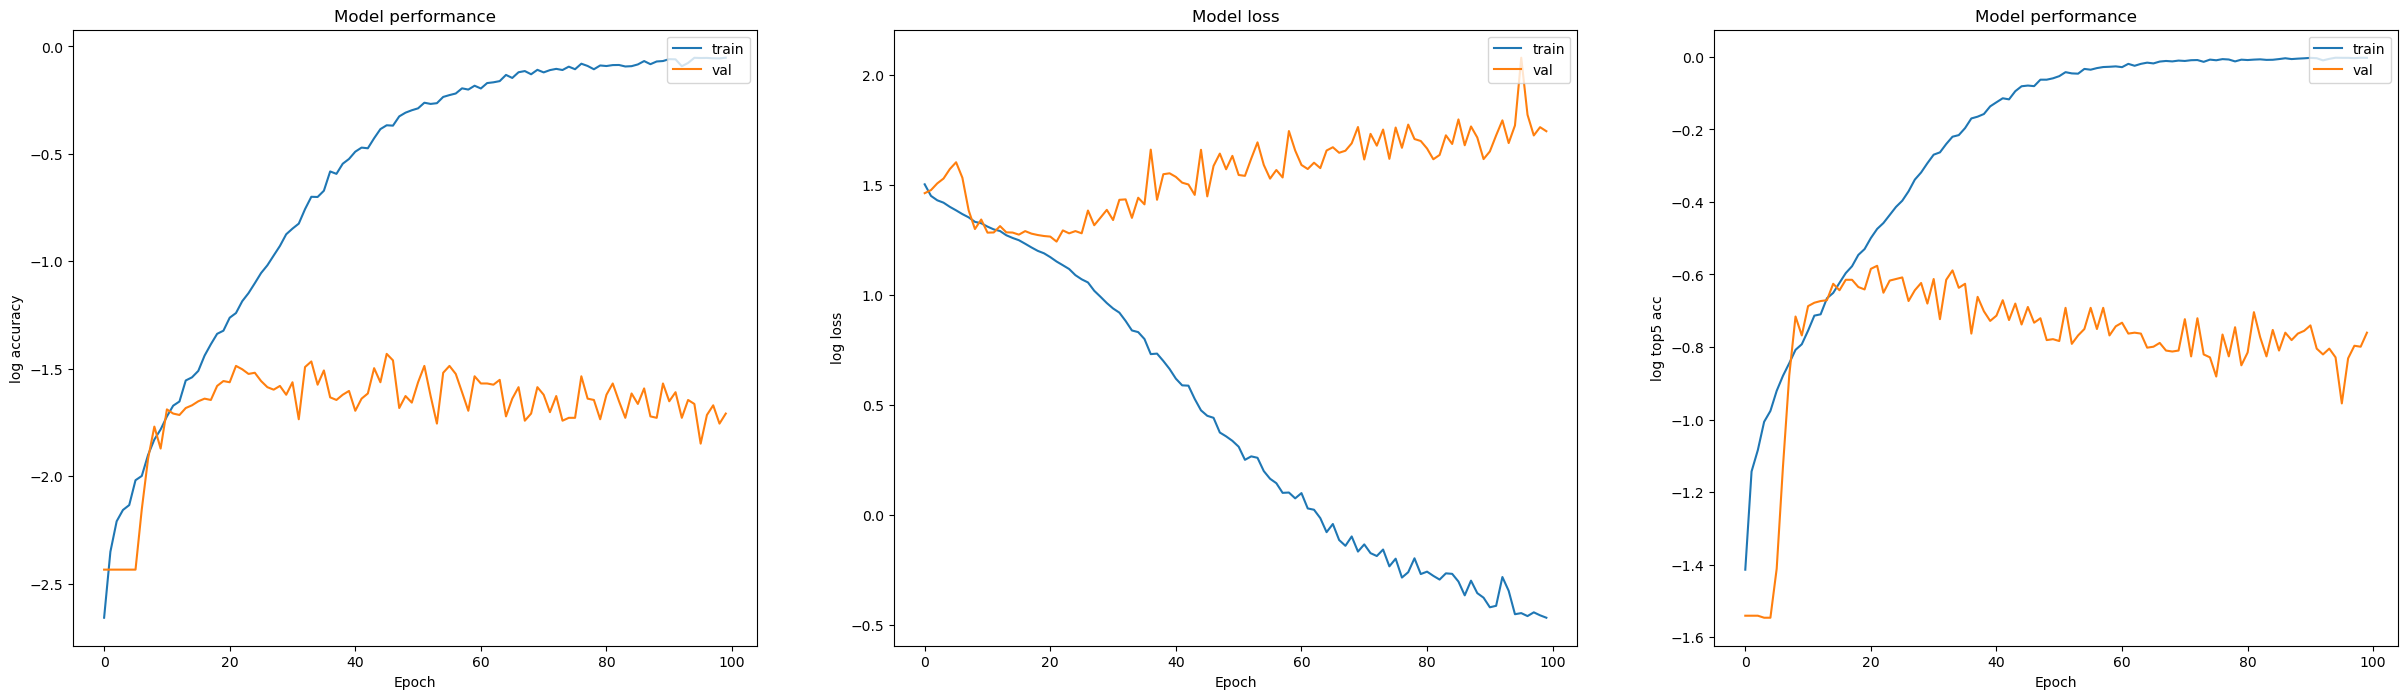

In [12]:
plot_learning_curves(history, False)
plot_learning_curves(history, True)

## 2. Dataset train_data_reshape(8446)

In [5]:
X_orig_reshape = np.load('train_data_reshape.npy')
Y_orig_reshape = to_categorical(np.load('train_labels_reshape.npy'))

In [6]:
X_train_reshape, Y_train_reshape, X_test_reshape, Y_test_reshape, X_dev_reshape, Y_dev_reshape = data_preprocess(X_orig_reshape, Y_orig_reshape)

X_train shape: (6756, 256, 256, 3)
Y_train shape: (6756, 50)
X_test shape: (845, 256, 256, 3)
Y_test shape: (845, 50)
X_dev shape: (845, 256, 256, 3)
Y_dev shape: (845, 50)


## 2. ResNet50

In [8]:
img_height,img_width = 256, 256 
num_classes = 50
base_model_reshape = applications.resnet50.ResNet50(weights= None, include_top=False, input_shape= (img_height,img_width,3))

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [11]:
x_reshape = base_model_reshape.output
x_reshape = GlobalAveragePooling2D()(x_reshape)
x_reshape = Dropout(0.7)(x_reshape)
predictions_reshape = Dense(num_classes, activation= 'softmax')(x_reshape)
model_reshape = Model(inputs = base_model_reshape.input, outputs = predictions_reshape)


In [12]:
# sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
adam = Adam(lr=0.0001)
model_reshape.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
history = model_reshape.fit(X_train_reshape, Y_train_reshape, epochs = 50, batch_size = 64, validation_data=(X_dev_reshape, Y_dev_reshape))
model_reshape.save('model_2')

Train on 6756 samples, validate on 845 samples
Epoch 1/50
6756/6756 [==============================] - 179s 27ms/step - loss: 4.7698 - accuracy: 0.0937 - val_loss: 3.6249 - val_accuracy: 0.0959
Epoch 2/50
6756/6756 [==============================] - 175s 26ms/step - loss: 3.8219 - accuracy: 0.1646 - val_loss: 3.8208 - val_accuracy: 0.1278
Epoch 3/50
6756/6756 [==============================] - 175s 26ms/step - loss: 3.5081 - accuracy: 0.1952 - val_loss: 3.5776 - val_accuracy: 0.1349
Epoch 4/50
6756/6756 [==============================] - 176s 26ms/step - loss: 3.2681 - accuracy: 0.2220 - val_loss: 3.1053 - val_accuracy: 0.2083
Epoch 5/50
6756/6756 [==============================] - 176s 26ms/step - loss: 3.1244 - accuracy: 0.2488 - val_loss: 2.8174 - val_accuracy: 0.2675
Epoch 6/50
6756/6756 [==============================] - 176s 26ms/step - loss: 2.9856 - accuracy: 0.2689 - val_loss: 3.1412 - val_accuracy: 0.2947
Epoch 7/50
6756/6756 [==============================] - 176s 26ms/step 

In [15]:
print(history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


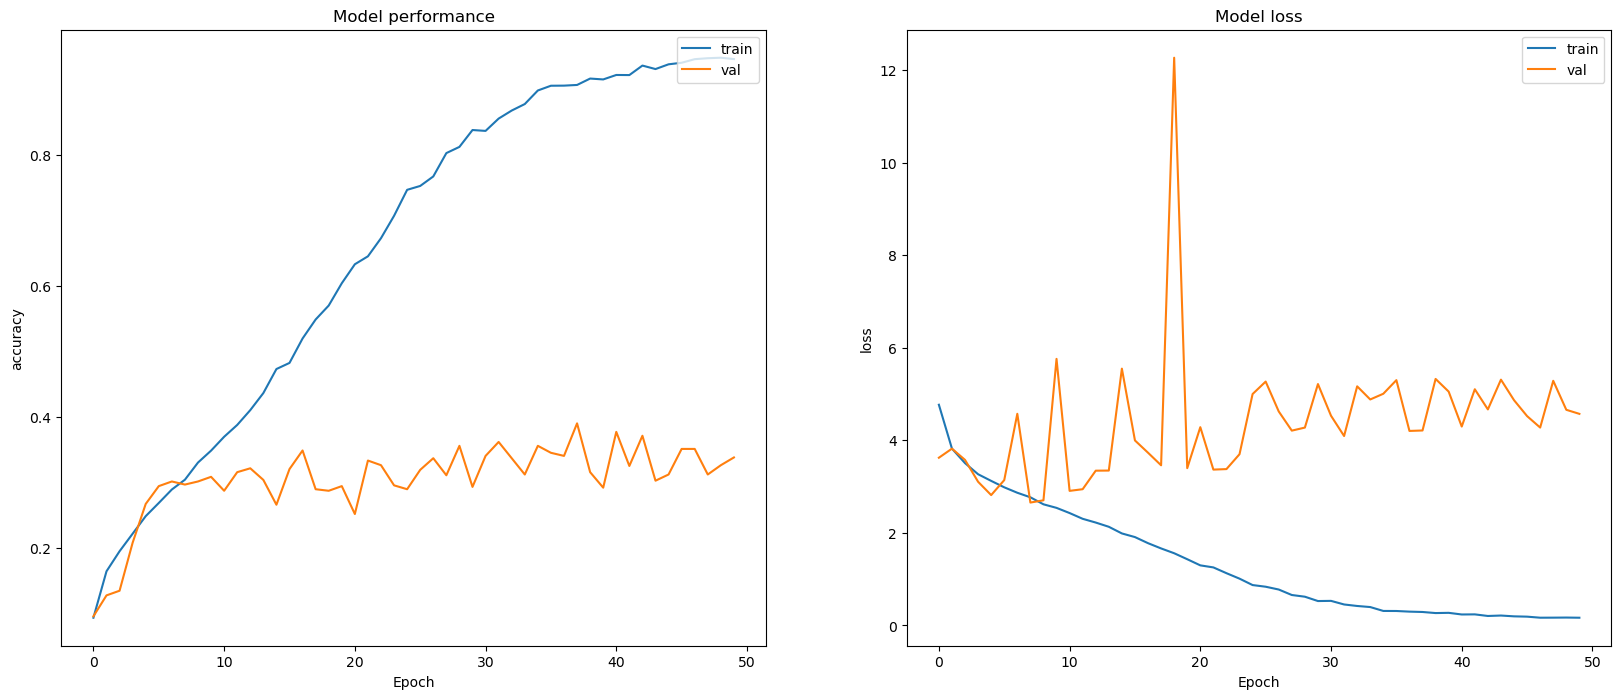

In [18]:
plot_learning_curves(history, False)

In [19]:
model2_temp = keras.models.load_model('model_2')

In [20]:
scores = model2_temp.evaluate(X_test_reshape, Y_test_reshape)

845/845 [==============================] - 5s 5ms/sample - loss: 4.4574 - accuracy: 0.3183


## 2b. ResNet50

In [6]:
img_height,img_width = 256, 256 
num_classes = 50
base_model_reshape = applications.resnet50.ResNet50(weights= None, include_top=False, input_shape= (img_height,img_width,3))

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [8]:
l2_model = add_regularization(base_model_reshape, regularizer=keras.regularizers.l2(0.01))
x_reshape = l2_model.output
x_reshape = GlobalAveragePooling2D()(x_reshape)
x_reshape = Dropout(0.9)(x_reshape)
predictions_reshape = Dense(num_classes, activation= 'softmax')(x_reshape)
model_reshape = Model(inputs = l2_model.input, outputs = predictions_reshape)

In [10]:
# sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
adam = Adam(lr=0.0001)
top5_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=5)
top5_acc.__name__ = 'top5_acc'
model_reshape.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['categorical_accuracy', top5_acc])

Train on 6756 samples, validate on 845 samples
Epoch 1/100
6756/6756 [==============================] - 205s 30ms/step - loss: 514.7791 - categorical_accuracy: 0.0554 - top5_acc: 0.1926 - val_loss: 485.4344 - val_categorical_accuracy: 0.1053 - val_top5_acc: 0.3728
Epoch 2/100
6756/6756 [==============================] - 177s 26ms/step - loss: 460.2031 - categorical_accuracy: 0.0912 - top5_acc: 0.2746 - val_loss: 431.8847 - val_categorical_accuracy: 0.1373 - val_top5_acc: 0.3680
Epoch 3/100
6756/6756 [==============================] - 176s 26ms/step - loss: 407.1352 - categorical_accuracy: 0.1196 - top5_acc: 0.3452 - val_loss: 381.0387 - val_categorical_accuracy: 0.1408 - val_top5_acc: 0.3633
Epoch 4/100
6756/6756 [==============================] - 176s 26ms/step - loss: 358.3532 - categorical_accuracy: 0.1456 - top5_acc: 0.3829 - val_loss: 335.0918 - val_categorical_accuracy: 0.1432 - val_top5_acc: 0.4071
Epoch 5/100
6756/6756 [==============================] - 176s 26ms/step - loss: 3

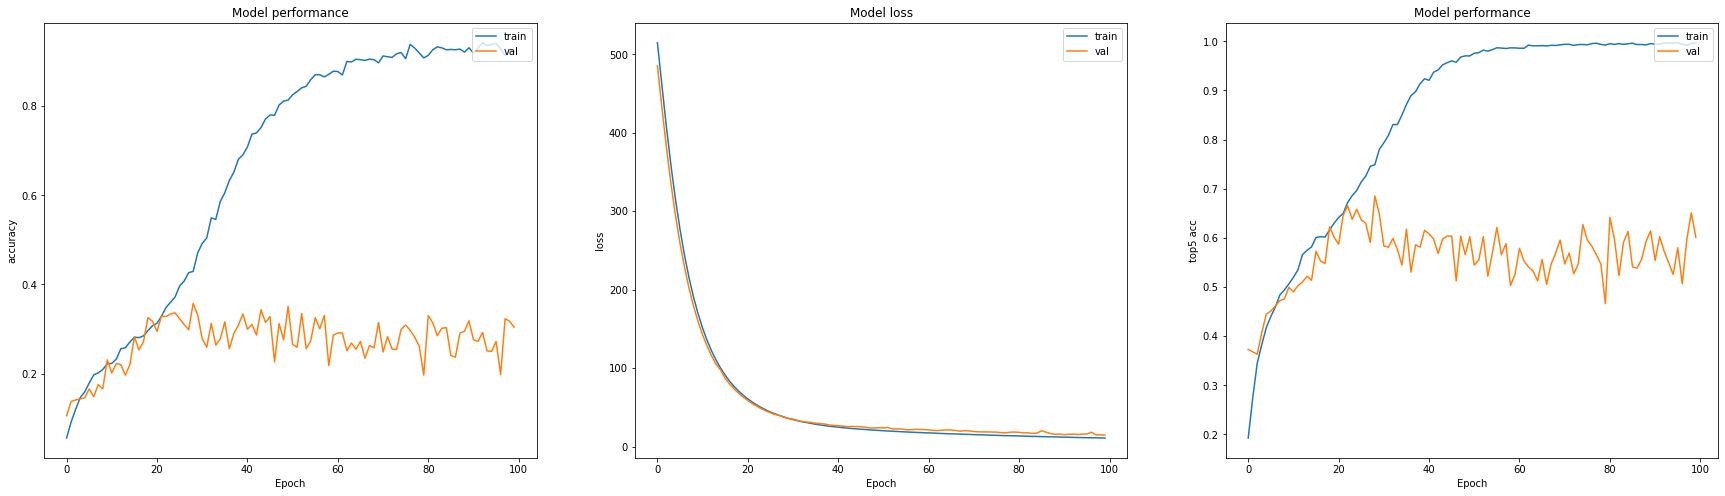

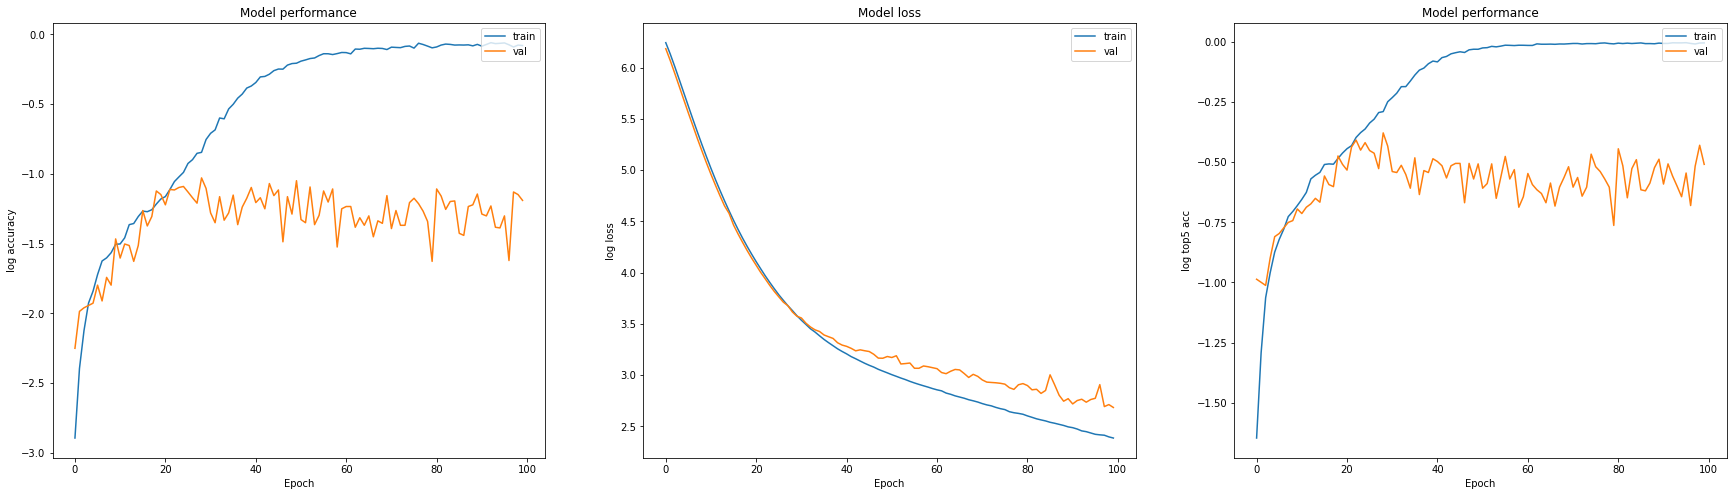

845/845 [==============================] - 6s 8ms/step
[14.64770703061798, 0.3041419982910156, 0.6011834144592285]


In [11]:
history = model_reshape.fit(X_train_reshape, Y_train_reshape, epochs = 100, batch_size = 64, validation_data=(X_dev_reshape, Y_dev_reshape))
model_reshape.save('model_2b')
plot_learning_curves(history, False)
plot_learning_curves(history, True)

#model_temp = keras.models.load_model('model_genre1e')
print(model_reshape.evaluate(X_dev_reshape, Y_dev_reshape))

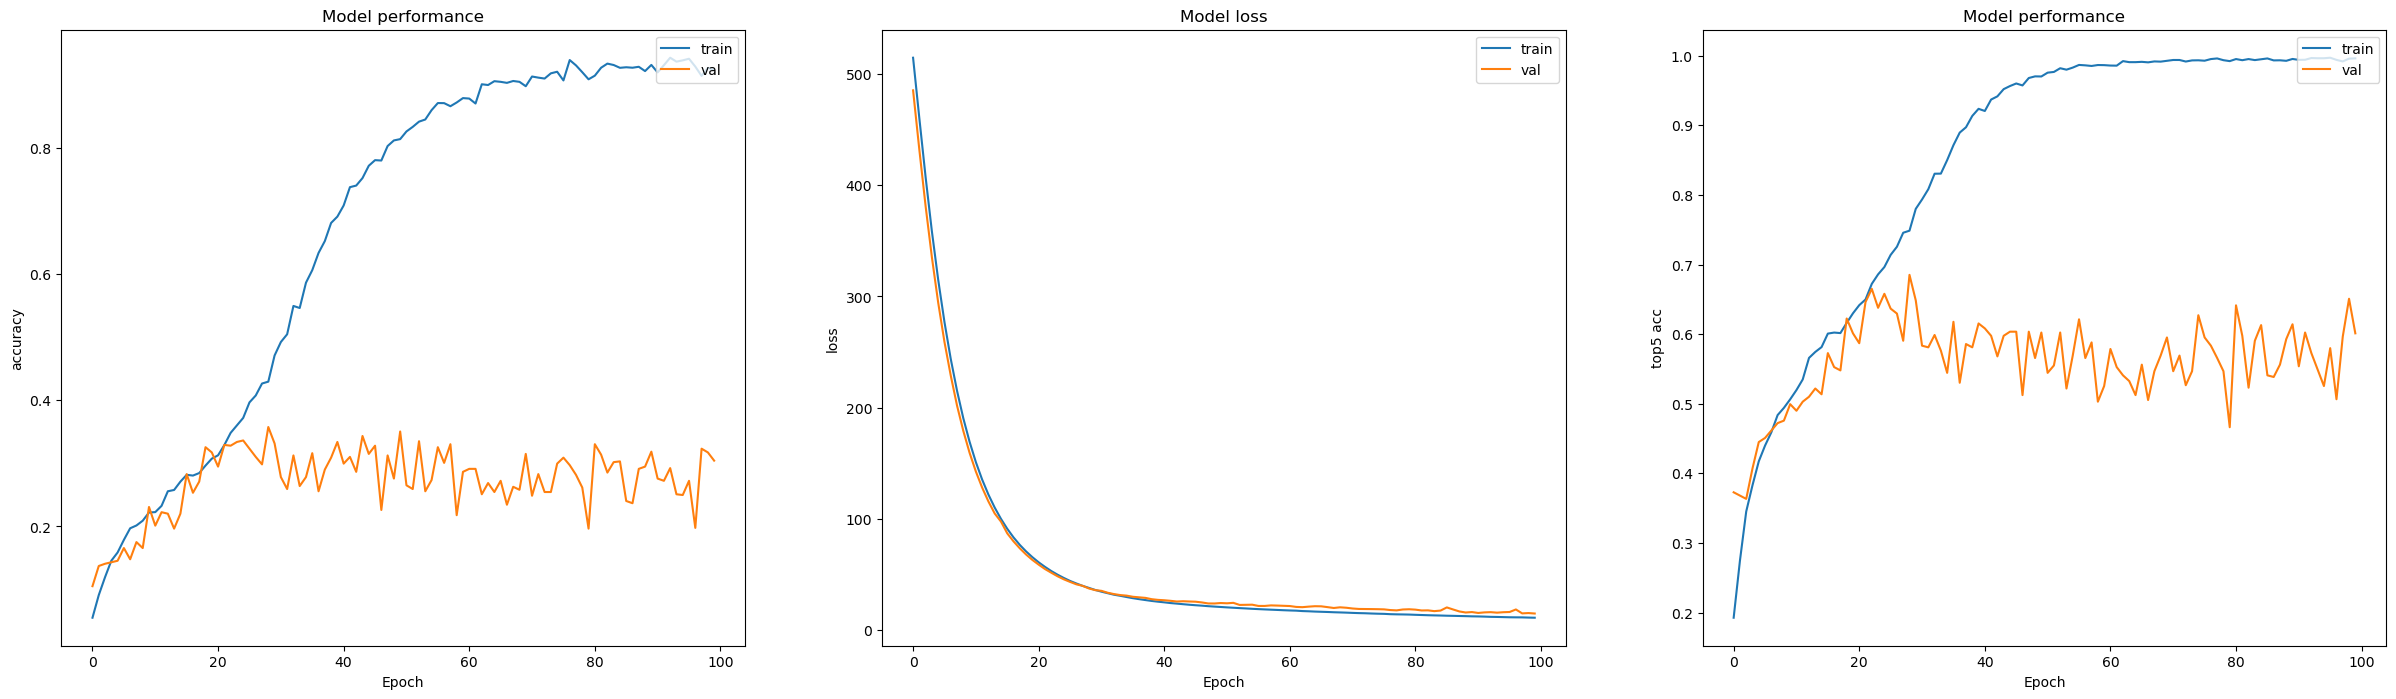

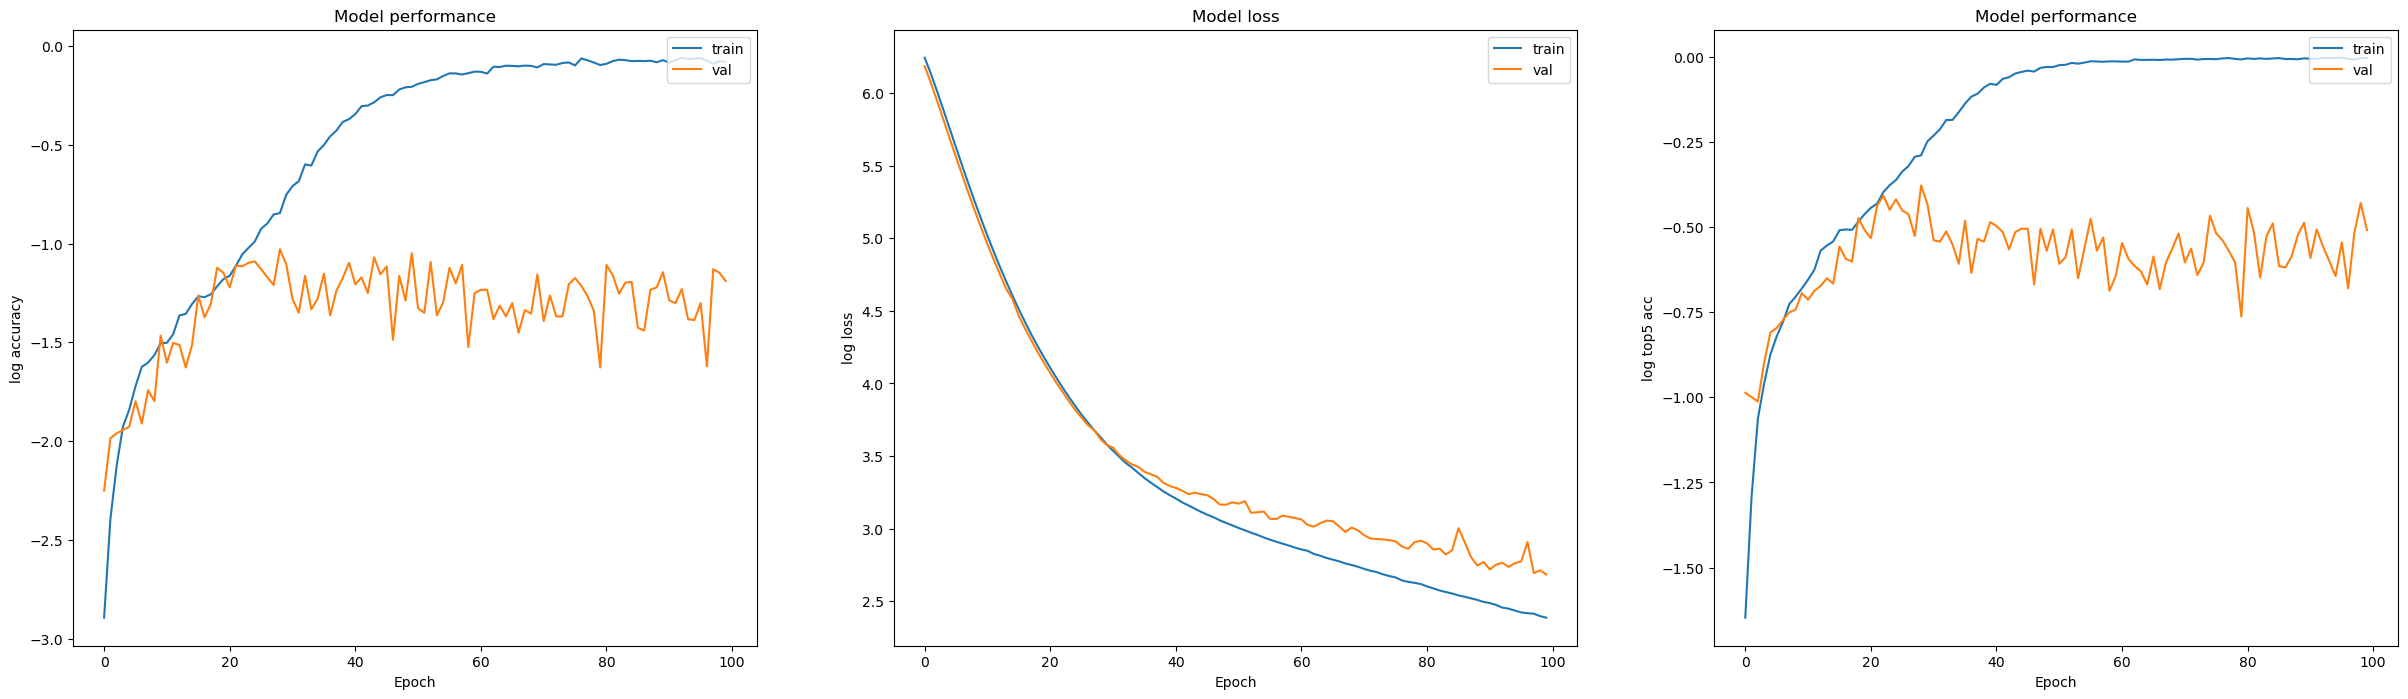

In [13]:
plot_learning_curves(history, False)
plot_learning_curves(history, True)

## 2c. MobileNet

In [14]:
img_height,img_width = 256, 256 
num_classes = 50
base_model_reshape = applications.MobileNet(weights= None, include_top=False, input_shape= (img_height,img_width,3))

In [15]:
l2_model = add_regularization(base_model_reshape, regularizer=keras.regularizers.l2(0.0001))
x_reshape = l2_model.output
x_reshape = GlobalAveragePooling2D()(x_reshape)
x_reshape = Dropout(0.7)(x_reshape)
predictions_reshape = Dense(num_classes, activation= 'softmax')(x_reshape)
model_reshape = Model(inputs = l2_model.input, outputs = predictions_reshape)

In [16]:
# sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
adam = Adam(lr=0.0001)
top5_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=5)
top5_acc.__name__ = 'top5_acc'
model_reshape.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['categorical_accuracy', top5_acc])

Train on 6756 samples, validate on 845 samples
Epoch 1/100
6756/6756 [==============================] - 110s 16ms/step - loss: 4.4253 - categorical_accuracy: 0.0768 - top5_acc: 0.2725 - val_loss: 4.2975 - val_categorical_accuracy: 0.0923 - val_top5_acc: 0.3006
Epoch 2/100
6756/6756 [==============================] - 99s 15ms/step - loss: 4.1599 - categorical_accuracy: 0.1243 - top5_acc: 0.3583 - val_loss: 4.3532 - val_categorical_accuracy: 0.0923 - val_top5_acc: 0.3006
Epoch 3/100
6756/6756 [==============================] - 100s 15ms/step - loss: 3.9786 - categorical_accuracy: 0.1496 - top5_acc: 0.4032 - val_loss: 4.5139 - val_categorical_accuracy: 0.0923 - val_top5_acc: 0.2959
Epoch 4/100
6756/6756 [==============================] - 99s 15ms/step - loss: 3.8341 - categorical_accuracy: 0.1812 - top5_acc: 0.4554 - val_loss: 4.6823 - val_categorical_accuracy: 0.0923 - val_top5_acc: 0.2959
Epoch 5/100
6756/6756 [==============================] - 99s 15ms/step - loss: 3.7230 - categorical

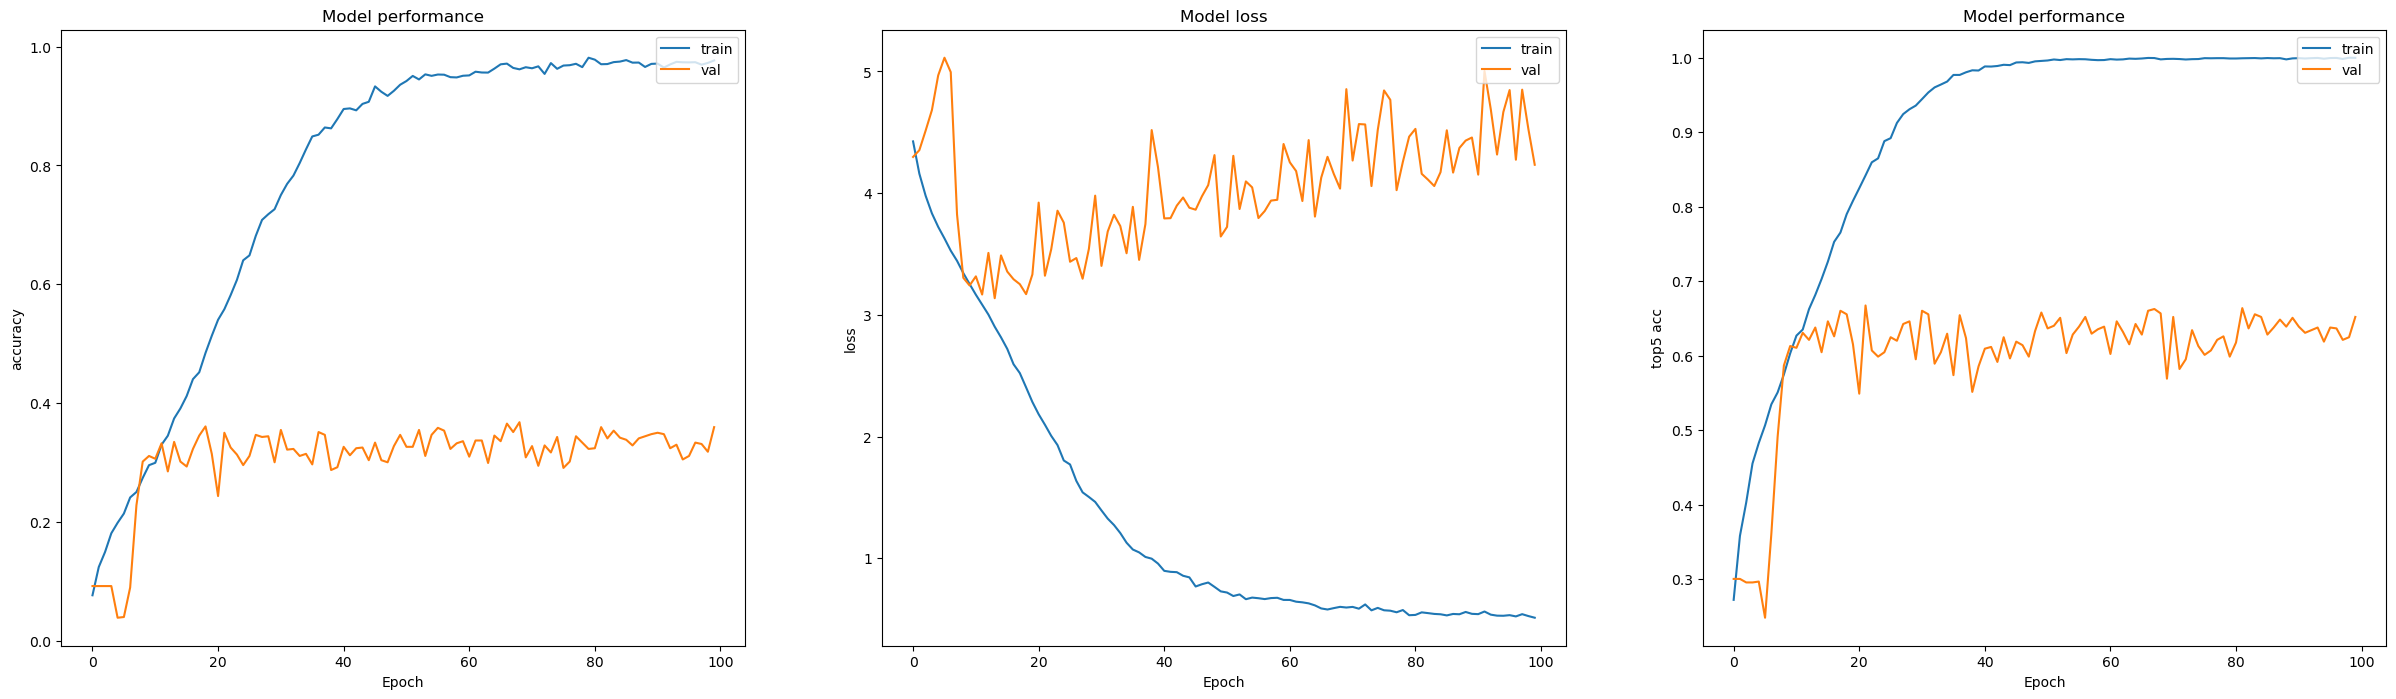

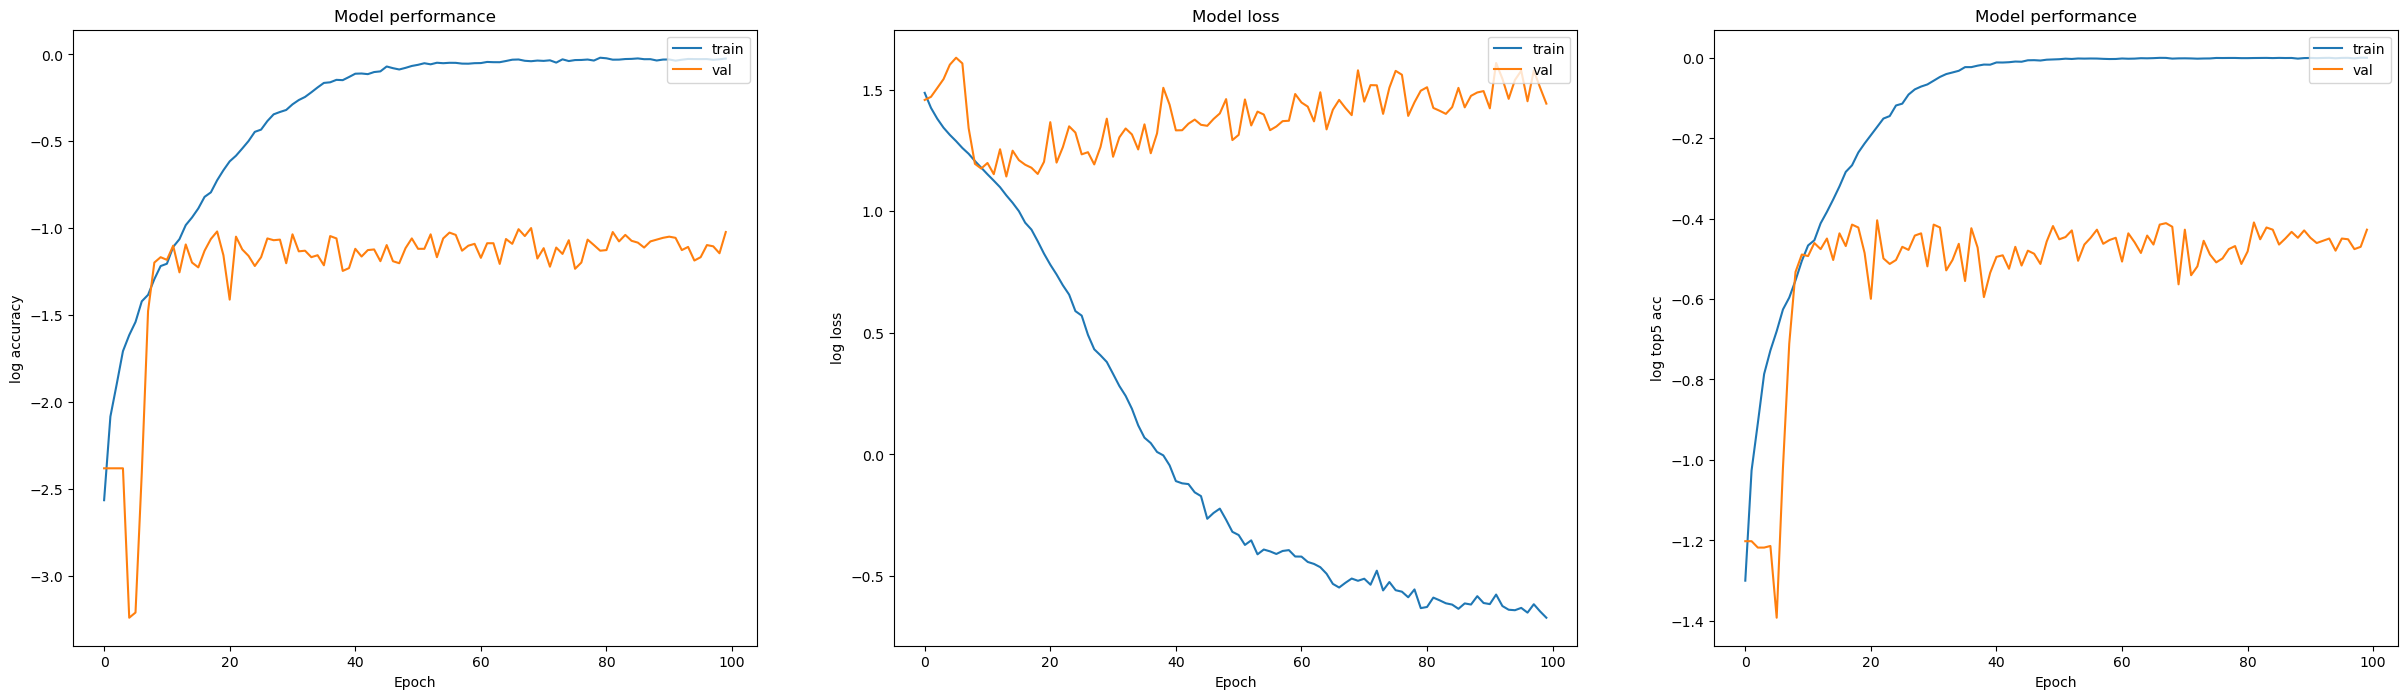

845/845 [==============================] - 3s 4ms/step
[4.233112937882102, 0.35976332426071167, 0.6520709991455078]


In [17]:
history = model_reshape.fit(X_train_reshape, Y_train_reshape, epochs = 100, batch_size = 64, validation_data=(X_dev_reshape, Y_dev_reshape))
model_reshape.save('model_2c')
plot_learning_curves(history, False)
plot_learning_curves(history, True)

#model_temp = keras.models.load_model('model_genre1e')
print(model_reshape.evaluate(X_dev_reshape, Y_dev_reshape))

## 2d ResNet50

In [7]:
img_height,img_width = 256, 256 
num_classes = 50
base_model_reshape = applications.resnet50.ResNet50(weights= None, include_top=False, input_shape= (img_height,img_width,3))

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [8]:
l2_model = add_regularization(base_model_reshape, regularizer=keras.regularizers.l2(0.0001))
x_reshape = l2_model.output
x_reshape = GlobalAveragePooling2D()(x_reshape)
x_reshape = Dropout(0.9)(x_reshape)
predictions_reshape = Dense(num_classes, activation= 'softmax')(x_reshape)
model_reshape = Model(inputs = l2_model.input, outputs = predictions_reshape)

In [9]:
# sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
adam = Adam(lr=0.0001)
top5_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=5)
top5_acc.__name__ = 'top5_acc'
model_reshape.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['categorical_accuracy', top5_acc])

Train on 6756 samples, validate on 845 samples
Epoch 1/100
6756/6756 [==============================] - 205s 30ms/step - loss: 12.0602 - categorical_accuracy: 0.0562 - top5_acc: 0.1982 - val_loss: 11.7993 - val_categorical_accuracy: 0.0923 - val_top5_acc: 0.3527
Epoch 2/100
6756/6756 [==============================] - 177s 26ms/step - loss: 10.1205 - categorical_accuracy: 0.0827 - top5_acc: 0.2858 - val_loss: 8.8879 - val_categorical_accuracy: 0.0888 - val_top5_acc: 0.3467
Epoch 3/100
6756/6756 [==============================] - 176s 26ms/step - loss: 9.4610 - categorical_accuracy: 0.1362 - top5_acc: 0.3609 - val_loss: 8.7581 - val_categorical_accuracy: 0.1219 - val_top5_acc: 0.3716
Epoch 4/100
6756/6756 [==============================] - 176s 26ms/step - loss: 9.1862 - categorical_accuracy: 0.1637 - top5_acc: 0.4066 - val_loss: 8.6797 - val_categorical_accuracy: 0.1704 - val_top5_acc: 0.4272
Epoch 5/100
6756/6756 [==============================] - 176s 26ms/step - loss: 8.9623 - categ

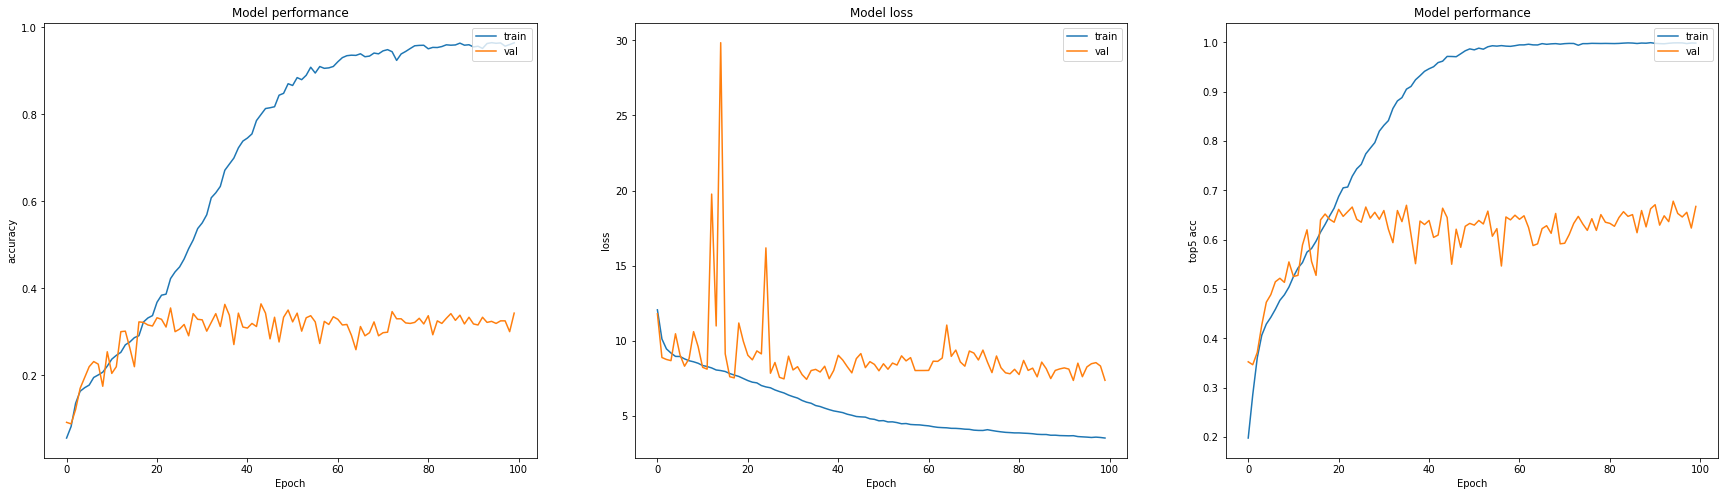

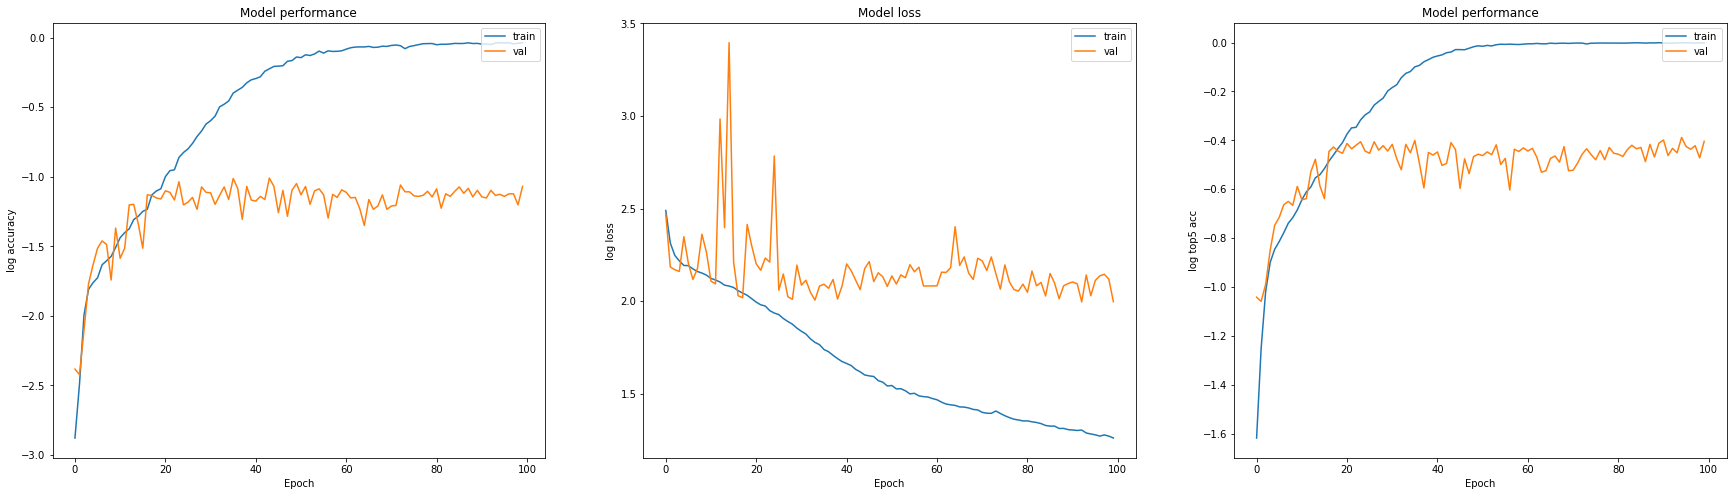

845/845 [==============================] - 7s 8ms/step
[7.370927770039033, 0.34319525957107544, 0.6674556136131287]


In [10]:
history = model_reshape.fit(X_train_reshape, Y_train_reshape, epochs = 100, batch_size = 64, validation_data=(X_dev_reshape, Y_dev_reshape))
model_reshape.save('model_2d')
plot_learning_curves(history, False)
plot_learning_curves(history, True)

#model_temp = keras.models.load_model('model_genre1e')
print(model_reshape.evaluate(X_dev_reshape, Y_dev_reshape))

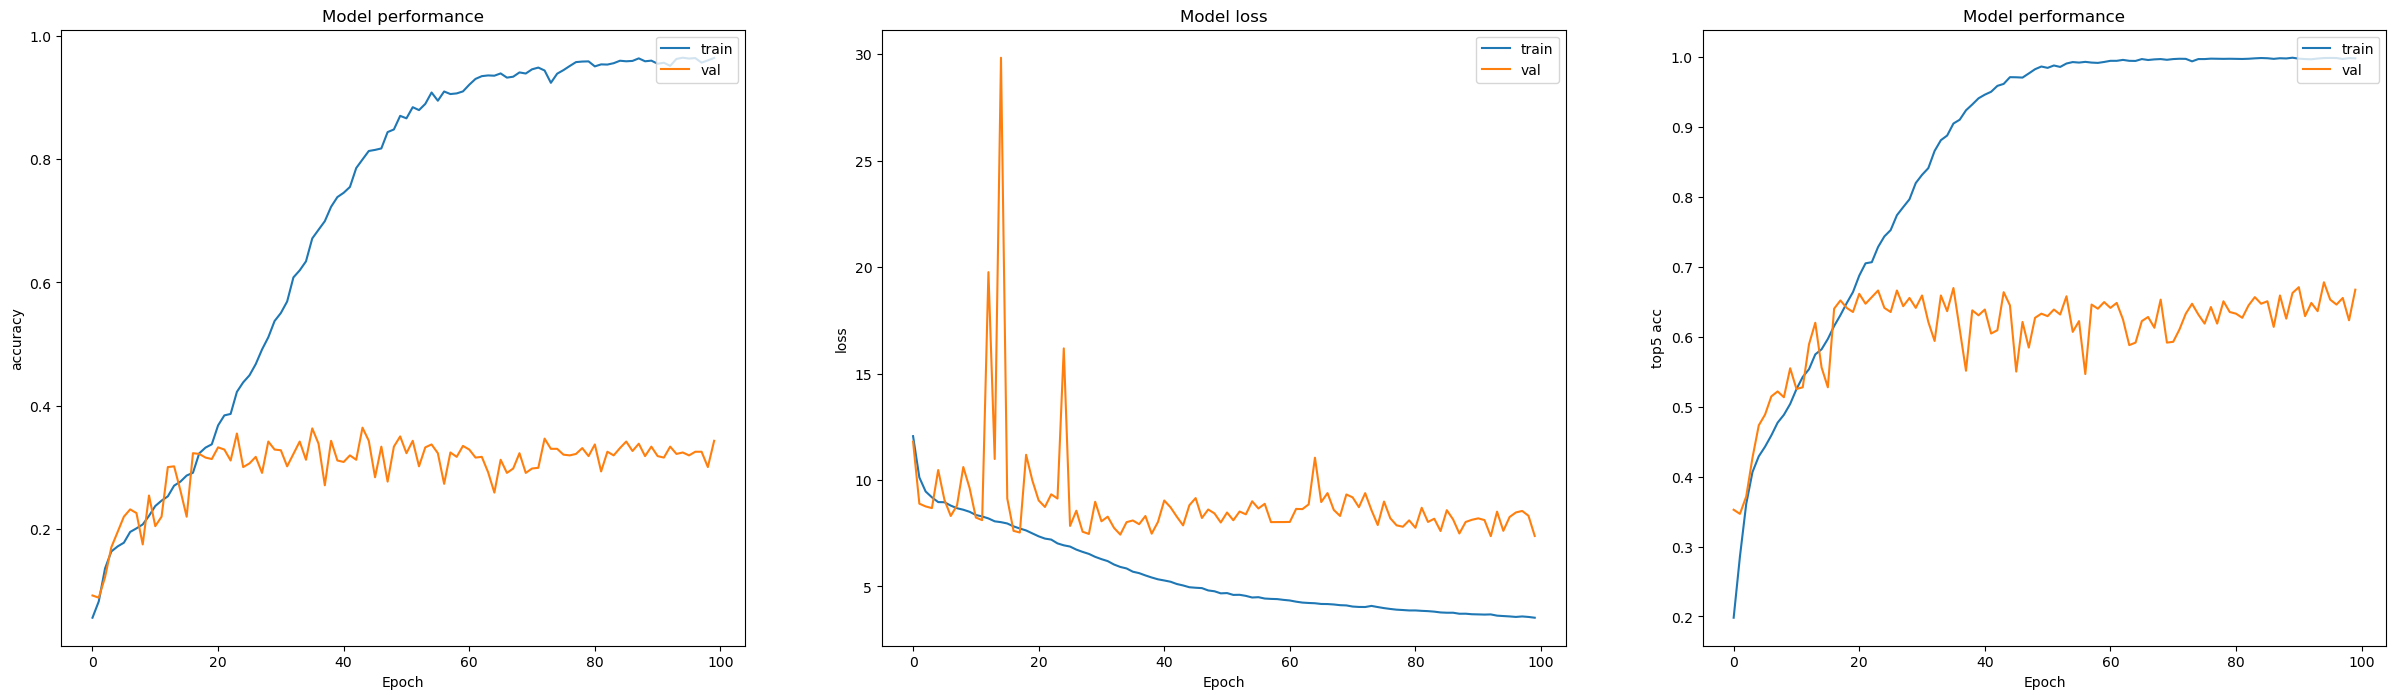

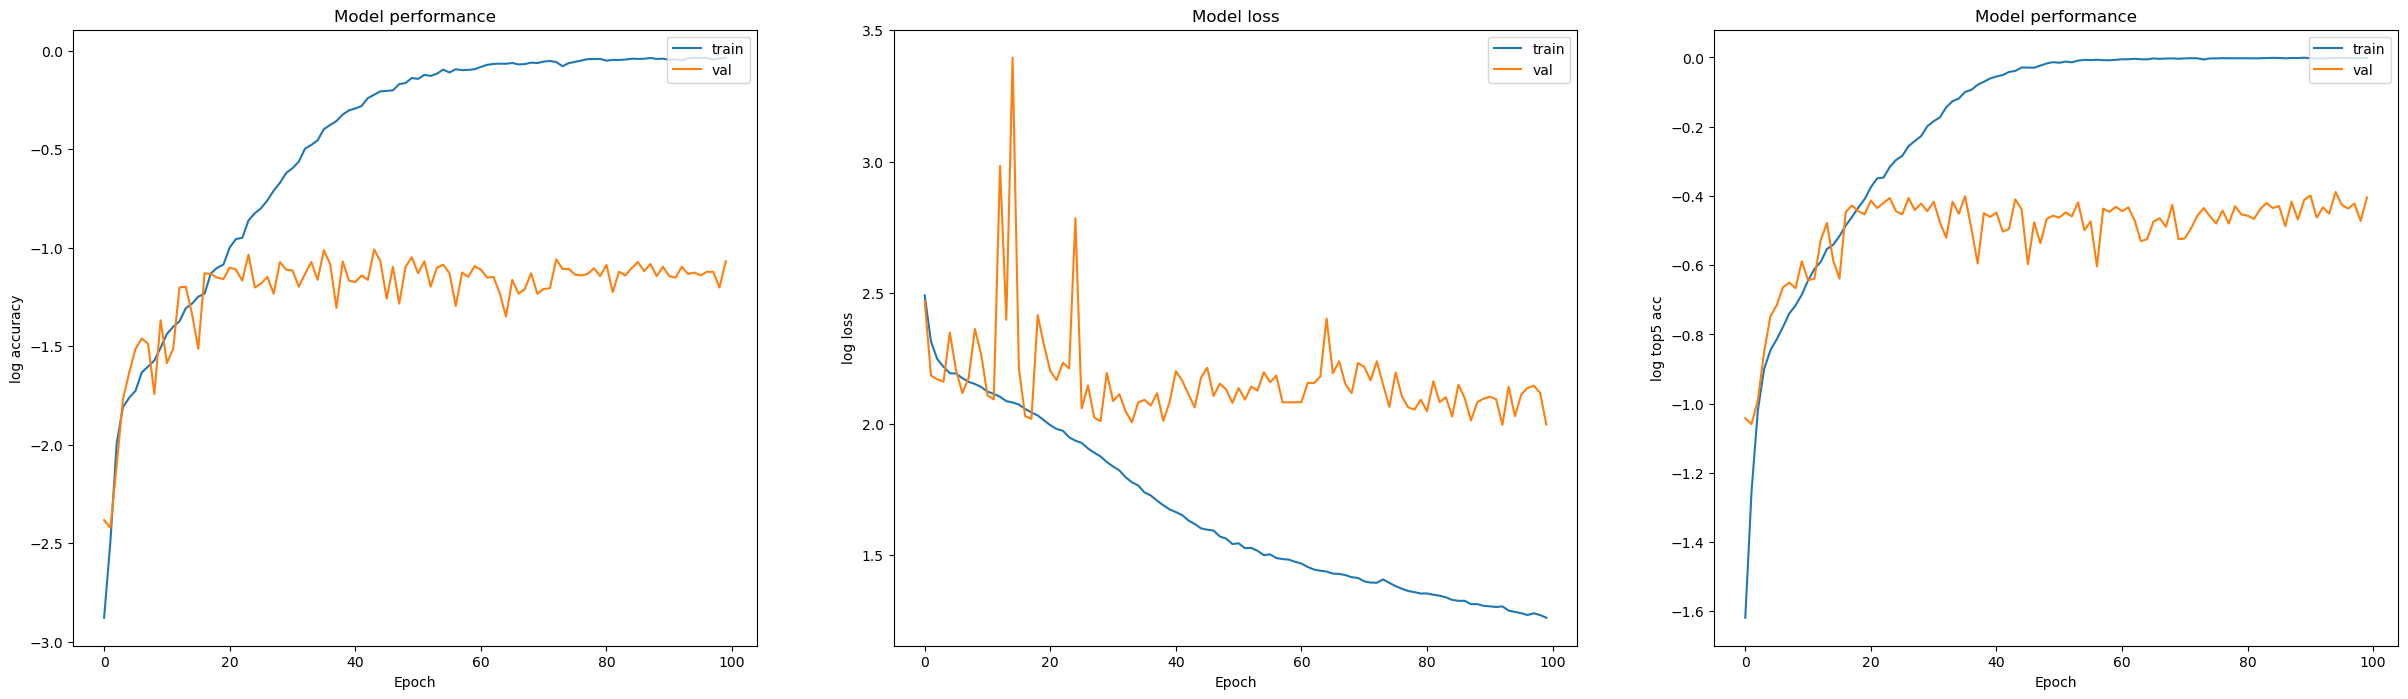

In [12]:
plot_learning_curves(history, False)
plot_learning_curves(history, True)

## 3. Dataset train_data_arg4.npy (33792)

In [4]:
X4_orig = np.load('train_data_arg4.npy')
Y4_orig = to_categorical(np.load('train_labels_arg4.npy'))

In [5]:
X4_train, Y4_train, X4_test, Y4_test, X4_dev, Y4_dev = data_preprocess(X4_orig, Y4_orig)

X_train shape: (27027, 128, 128, 3)
Y_train shape: (27027, 50)
X_test shape: (3378, 128, 128, 3)
Y_test shape: (3378, 50)
X_dev shape: (3379, 128, 128, 3)
Y_dev shape: (3379, 50)


## 3b. Arg 4 Resnet50

In [5]:
img_height,img_width = 128, 128
num_classes = 50
base_model_aug4 = applications.resnet50.ResNet50(weights= None, include_top=False, input_shape= (img_height,img_width,3))

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [6]:
x_aug4 = base_model_aug4.output
x_aug4 = GlobalAveragePooling2D()(x_aug4)
x_aug4 = Dropout(0.7)(x_aug4)
predictions_aug4 = Dense(num_classes, activation= 'softmax')(x_aug4)
model_aug4 = Model(inputs = base_model_aug4.input, outputs = predictions_aug4)

In [8]:
# sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
adam = Adam(lr=0.0001)
model_aug4.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
history = model_aug4.fit(X4_train, Y4_train, epochs = 50, batch_size = 64, validation_data=(X4_dev, Y4_dev))
model_aug4.save('model_3b')

Train on 27027 samples, validate on 3379 samples
Epoch 1/50
27027/27027 [==============================] - 209s 8ms/step - loss: 4.4355 - accuracy: 0.1051 - val_loss: 3.6380 - val_accuracy: 0.1619
Epoch 2/50
27027/27027 [==============================] - 183s 7ms/step - loss: 3.6646 - accuracy: 0.1573 - val_loss: 7.7231 - val_accuracy: 0.1826
Epoch 3/50
27027/27027 [==============================] - 184s 7ms/step - loss: 3.3905 - accuracy: 0.1790 - val_loss: 3.6065 - val_accuracy: 0.2021
Epoch 4/50
27027/27027 [==============================] - 183s 7ms/step - loss: 3.2285 - accuracy: 0.1981 - val_loss: 3.9900 - val_accuracy: 0.2069
Epoch 5/50
27027/27027 [==============================] - 183s 7ms/step - loss: 3.1103 - accuracy: 0.2131 - val_loss: 2.9987 - val_accuracy: 0.2329
Epoch 6/50
27027/27027 [==============================] - 184s 7ms/step - loss: 3.0218 - accuracy: 0.2265 - val_loss: 2.9521 - val_accuracy: 0.2382
Epoch 7/50
27027/27027 [==============================] - 183s 

In [14]:
print(history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


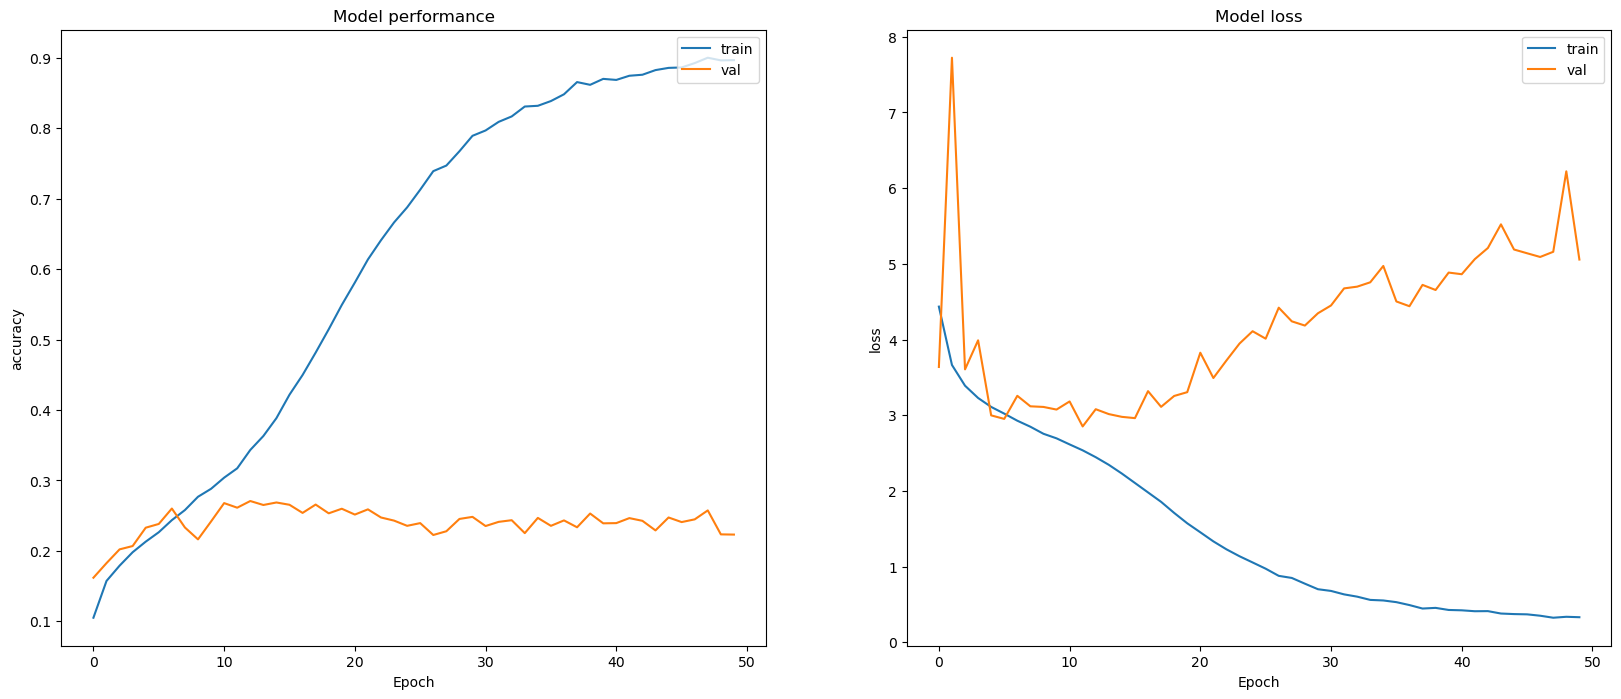

In [15]:
plot_learning_curves(history, False)

In [16]:
!ls model_3b

model_3b


In [17]:
model3b_temp = keras.models.load_model('model_3b')

In [19]:
scores = model3b_temp.evaluate(X4_test, Y4_test)

3378/3378 [==============================] - 5s 2ms/sample - loss: 4.9337 - accuracy: 0.2342


In [20]:
model3_temp = keras.models.load_model('model_3')

In [21]:
scores = model3_temp.evaluate(X4_test, Y4_test)

3378/3378 [==============================] - 4s 1ms/sample - loss: 1.5391 - accuracy: 0.7768


## 3c MobileNet

In [10]:
img_height,img_width = 128, 128
num_classes = 50
base_model_aug4 = applications.MobileNet(weights= None, include_top=False, input_shape= (img_height,img_width,3))

In [11]:
l2_model = add_regularization(base_model_aug4, regularizer=keras.regularizers.l2(0.0001))
x_aug4 = l2_model.output
x_aug4 = GlobalAveragePooling2D()(x_aug4)
x_aug4 = Dropout(0.7)(x_aug4)
predictions_aug4 = Dense(num_classes, activation= 'softmax')(x_aug4)
model_aug4 = Model(inputs = l2_model.input, outputs = predictions_aug4)

In [12]:
# sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
adam = Adam(lr=0.0001)
top5_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=5)
top5_acc.__name__ = 'top5_acc'
model_aug4.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['categorical_accuracy', top5_acc])

Train on 27027 samples, validate on 3379 samples
Epoch 1/100
27027/27027 [==============================] - 100s 4ms/step - loss: 4.4352 - categorical_accuracy: 0.0805 - top5_acc: 0.2711 - val_loss: 4.4054 - val_categorical_accuracy: 0.0879 - val_top5_acc: 0.2282
Epoch 2/100
27027/27027 [==============================] - 93s 3ms/step - loss: 4.1999 - categorical_accuracy: 0.1054 - top5_acc: 0.3293 - val_loss: 4.0107 - val_categorical_accuracy: 0.1326 - val_top5_acc: 0.3906
Epoch 3/100
27027/27027 [==============================] - 93s 3ms/step - loss: 4.0445 - categorical_accuracy: 0.1240 - top5_acc: 0.3772 - val_loss: 3.8154 - val_categorical_accuracy: 0.1592 - val_top5_acc: 0.4484
Epoch 4/100
27027/27027 [==============================] - 92s 3ms/step - loss: 3.9405 - categorical_accuracy: 0.1378 - top5_acc: 0.4061 - val_loss: 3.7526 - val_categorical_accuracy: 0.1672 - val_top5_acc: 0.4720
Epoch 5/100
27027/27027 [==============================] - 92s 3ms/step - loss: 3.8572 - categ

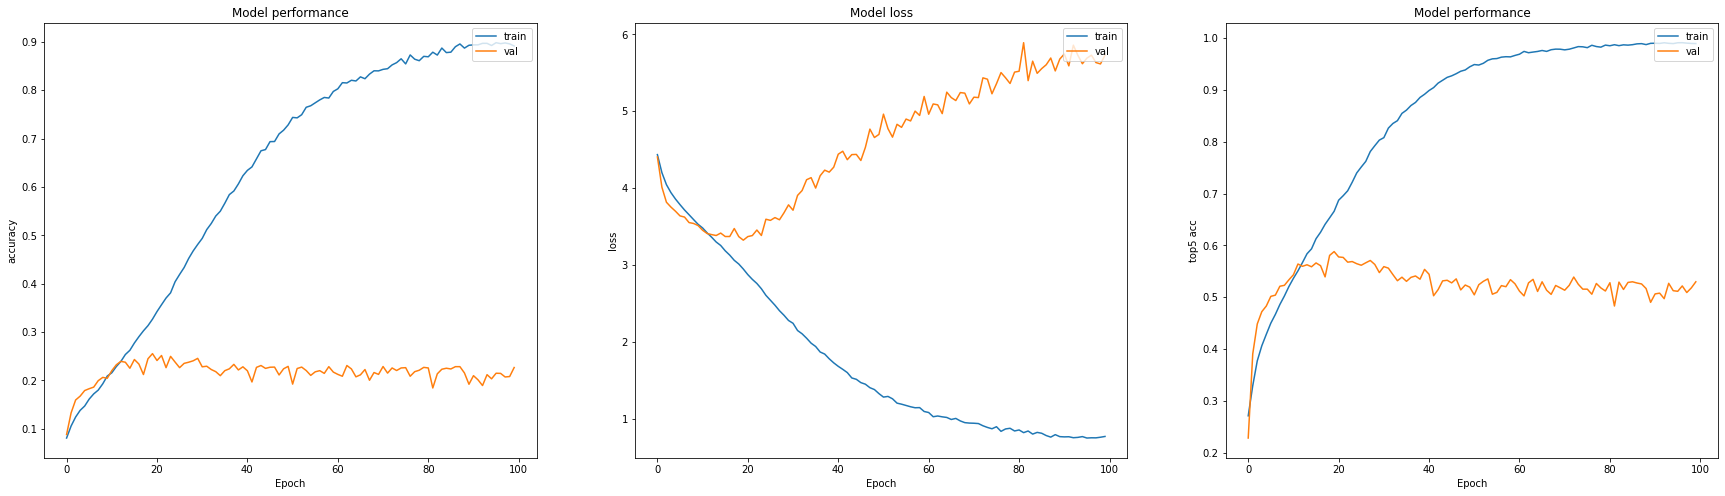

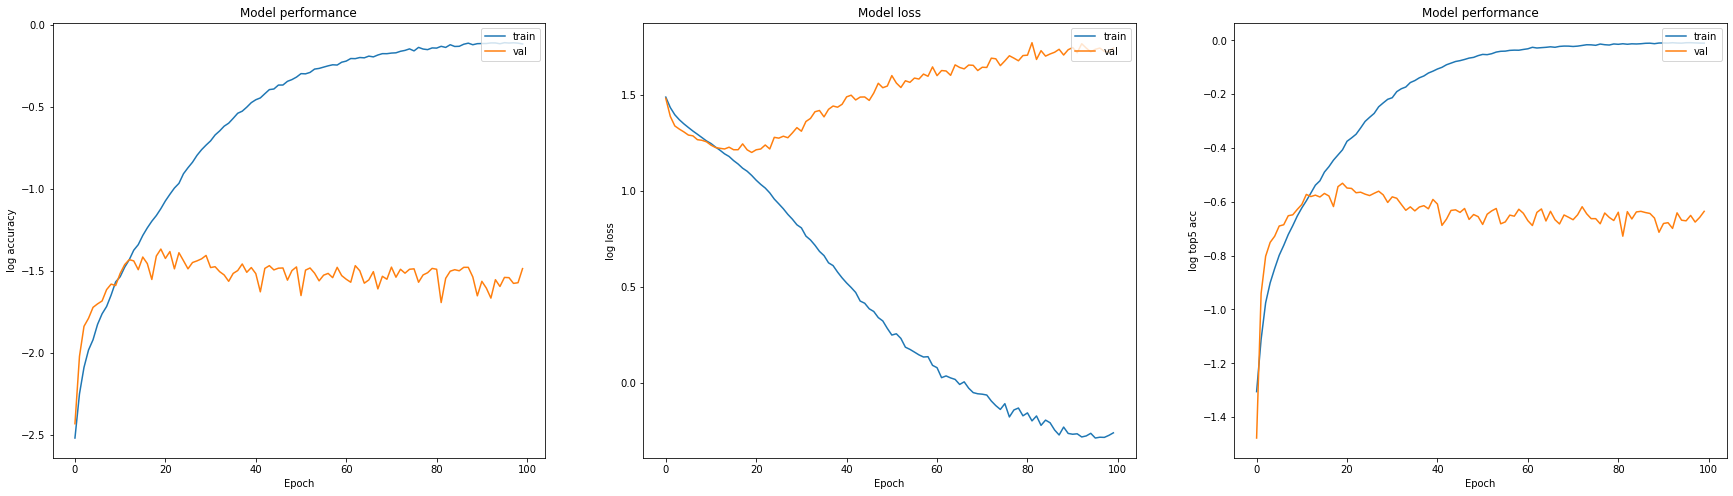

NameError: name 'model' is not defined

In [13]:
history = model_aug4.fit(X4_train, Y4_train, epochs = 100, batch_size = 64, validation_data=(X4_dev, Y4_dev))
model_aug4.save('model3c')
plot_learning_curves(history, False)
plot_learning_curves(history, True)

#model_temp = keras.models.load_model('model_genre1e')
#print(model.evaluate(X4_dev, Y4_dev))

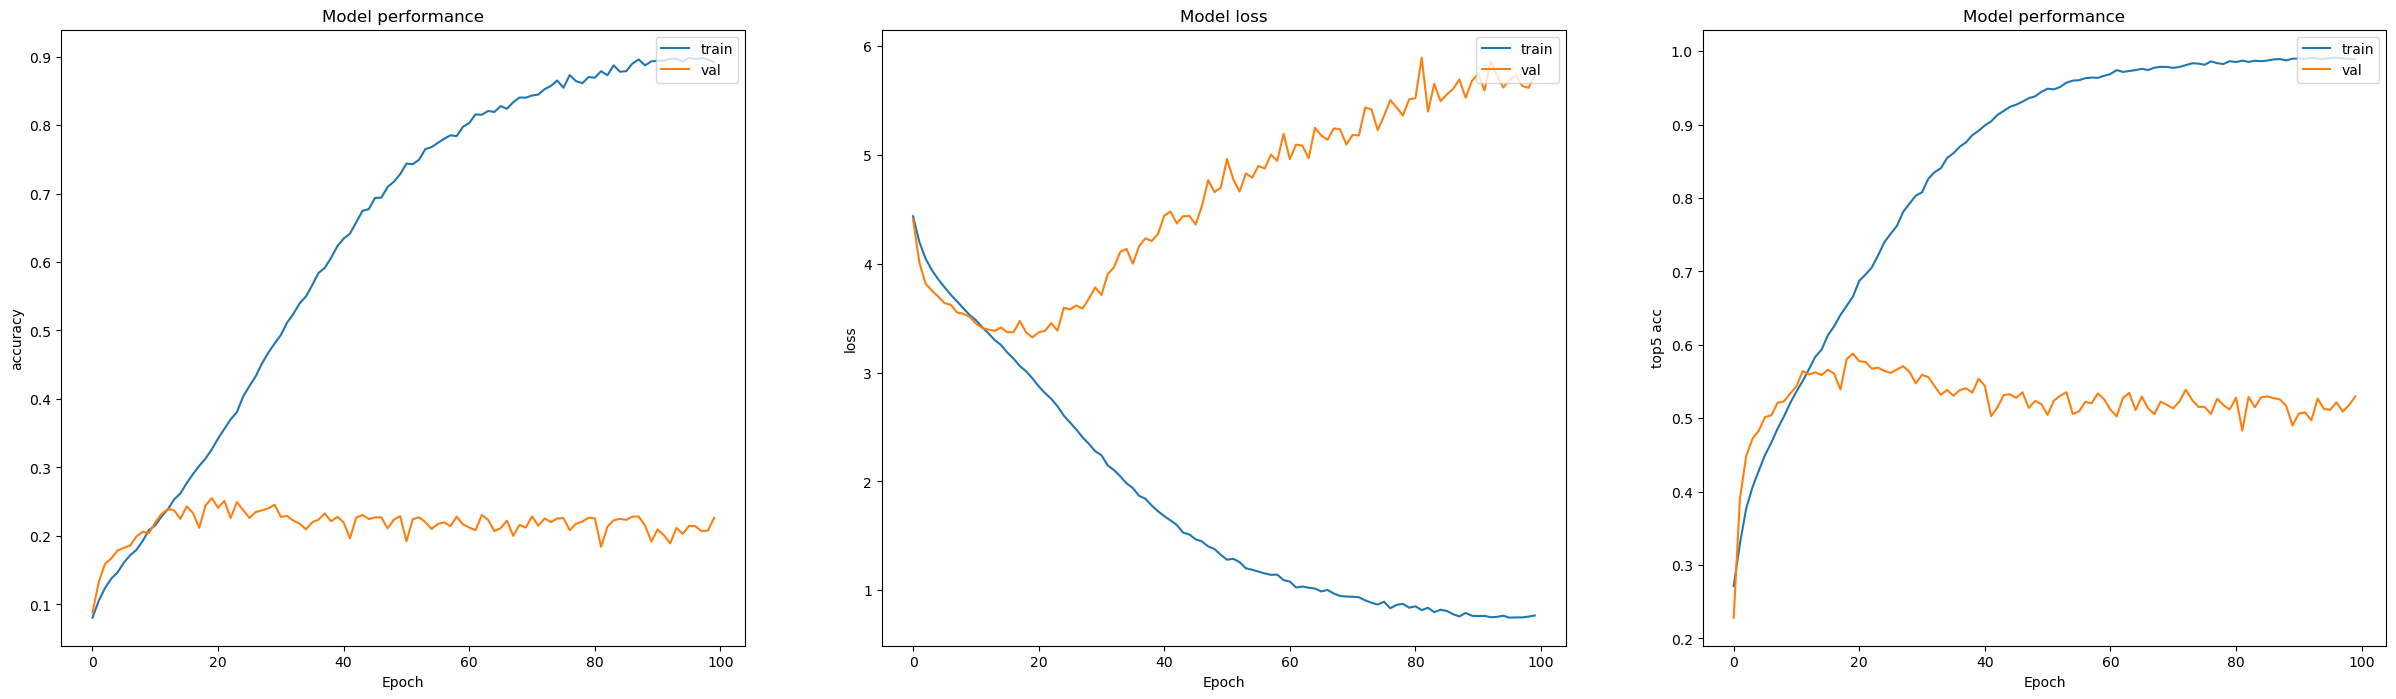

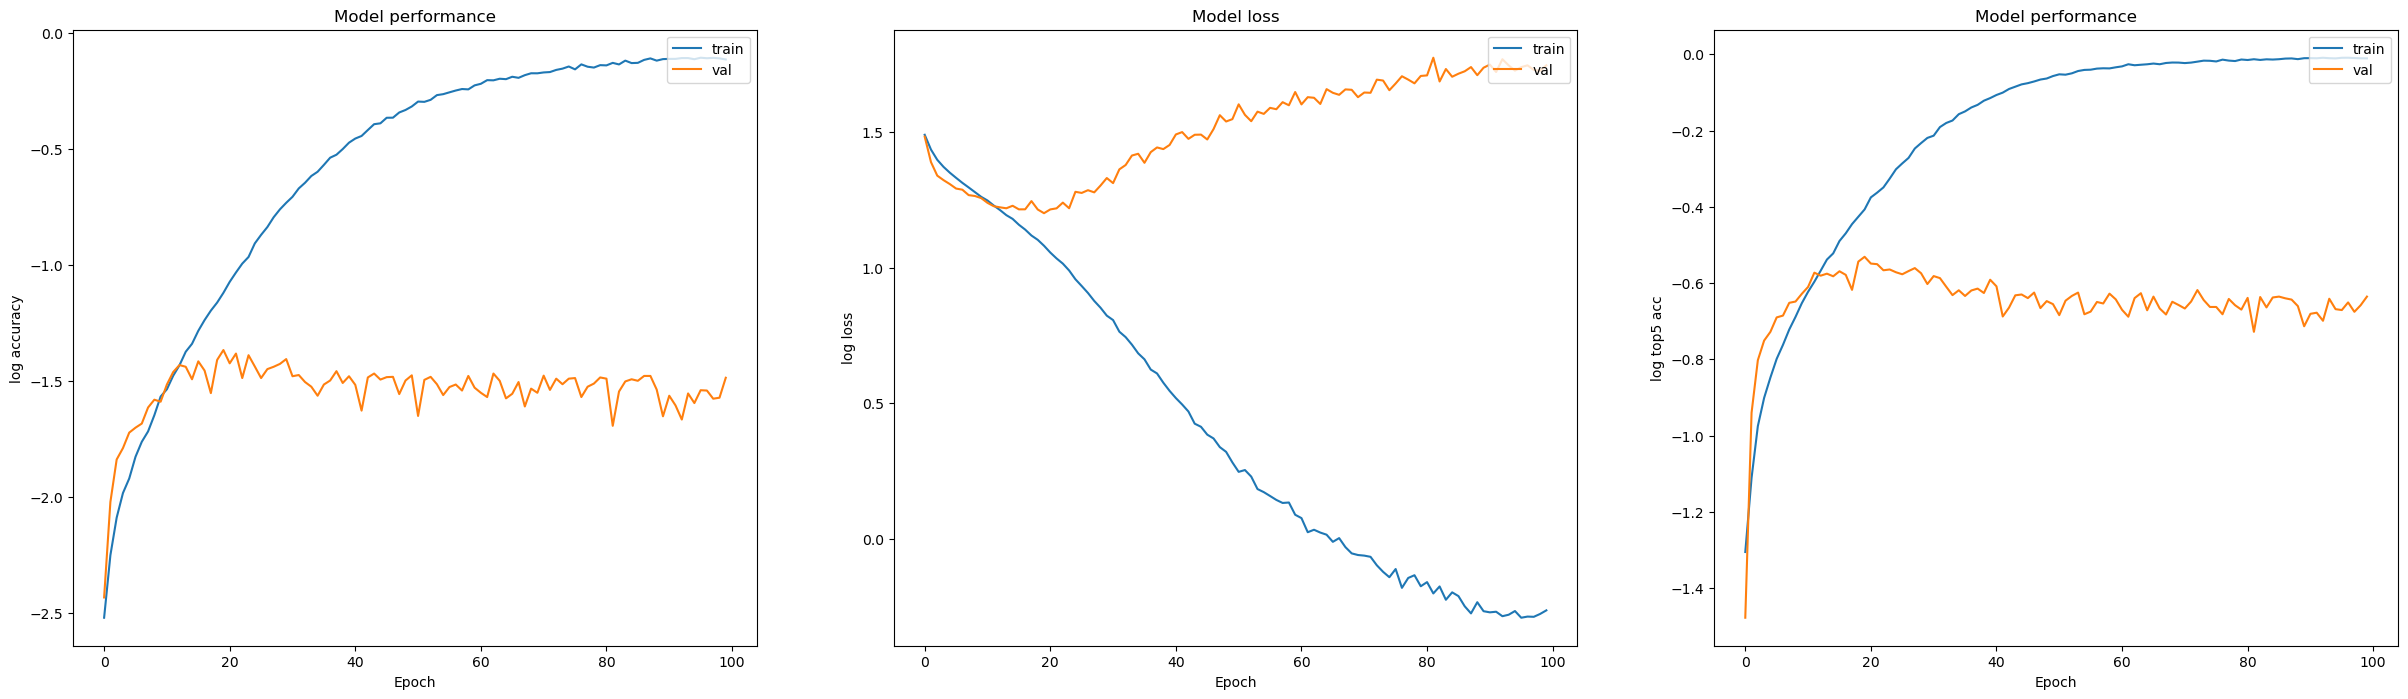

3379/3379 [==============================] - 3s 883us/step
[5.729068418126305, 0.22639834880828857, 0.5297425389289856]


In [15]:
plot_learning_curves(history, False)
plot_learning_curves(history, True)
print(model_aug4.evaluate(X4_dev, Y4_dev))


## 3d ResNet50

In [16]:
img_height,img_width = 128, 128
num_classes = 50
base_model_aug4 = applications.resnet50.ResNet50(weights= None, include_top=False, input_shape= (img_height,img_width,3))

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [17]:
l2_model = add_regularization(base_model_aug4, regularizer=keras.regularizers.l2(0.0001))
x_aug4 = l2_model.output
x_aug4 = GlobalAveragePooling2D()(x_aug4)
x_aug4 = Dropout(0.7)(x_aug4)
predictions_aug4 = Dense(num_classes, activation= 'softmax')(x_aug4)
model_aug4 = Model(inputs = l2_model.input, outputs = predictions_aug4)

In [18]:
# sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
adam = Adam(lr=0.0001)
top5_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=5)
top5_acc.__name__ = 'top5_acc'
model_aug4.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['categorical_accuracy', top5_acc])

Train on 27027 samples, validate on 3379 samples
Epoch 1/100
27027/27027 [==============================] - 204s 8ms/step - loss: 9.7742 - categorical_accuracy: 0.1053 - top5_acc: 0.3152 - val_loss: 8.6154 - val_categorical_accuracy: 0.1740 - val_top5_acc: 0.4392
Epoch 2/100
27027/27027 [==============================] - 186s 7ms/step - loss: 8.9136 - categorical_accuracy: 0.1517 - top5_acc: 0.4160 - val_loss: 8.9387 - val_categorical_accuracy: 0.1930 - val_top5_acc: 0.5025
Epoch 3/100
27027/27027 [==============================] - 185s 7ms/step - loss: 8.5710 - categorical_accuracy: 0.1758 - top5_acc: 0.4643 - val_loss: 8.5304 - val_categorical_accuracy: 0.2143 - val_top5_acc: 0.5235
Epoch 4/100
27027/27027 [==============================] - 185s 7ms/step - loss: 8.3170 - categorical_accuracy: 0.1940 - top5_acc: 0.4960 - val_loss: 8.1732 - val_categorical_accuracy: 0.2291 - val_top5_acc: 0.5555
Epoch 5/100
27027/27027 [==============================] - 184s 7ms/step - loss: 8.1061 - c

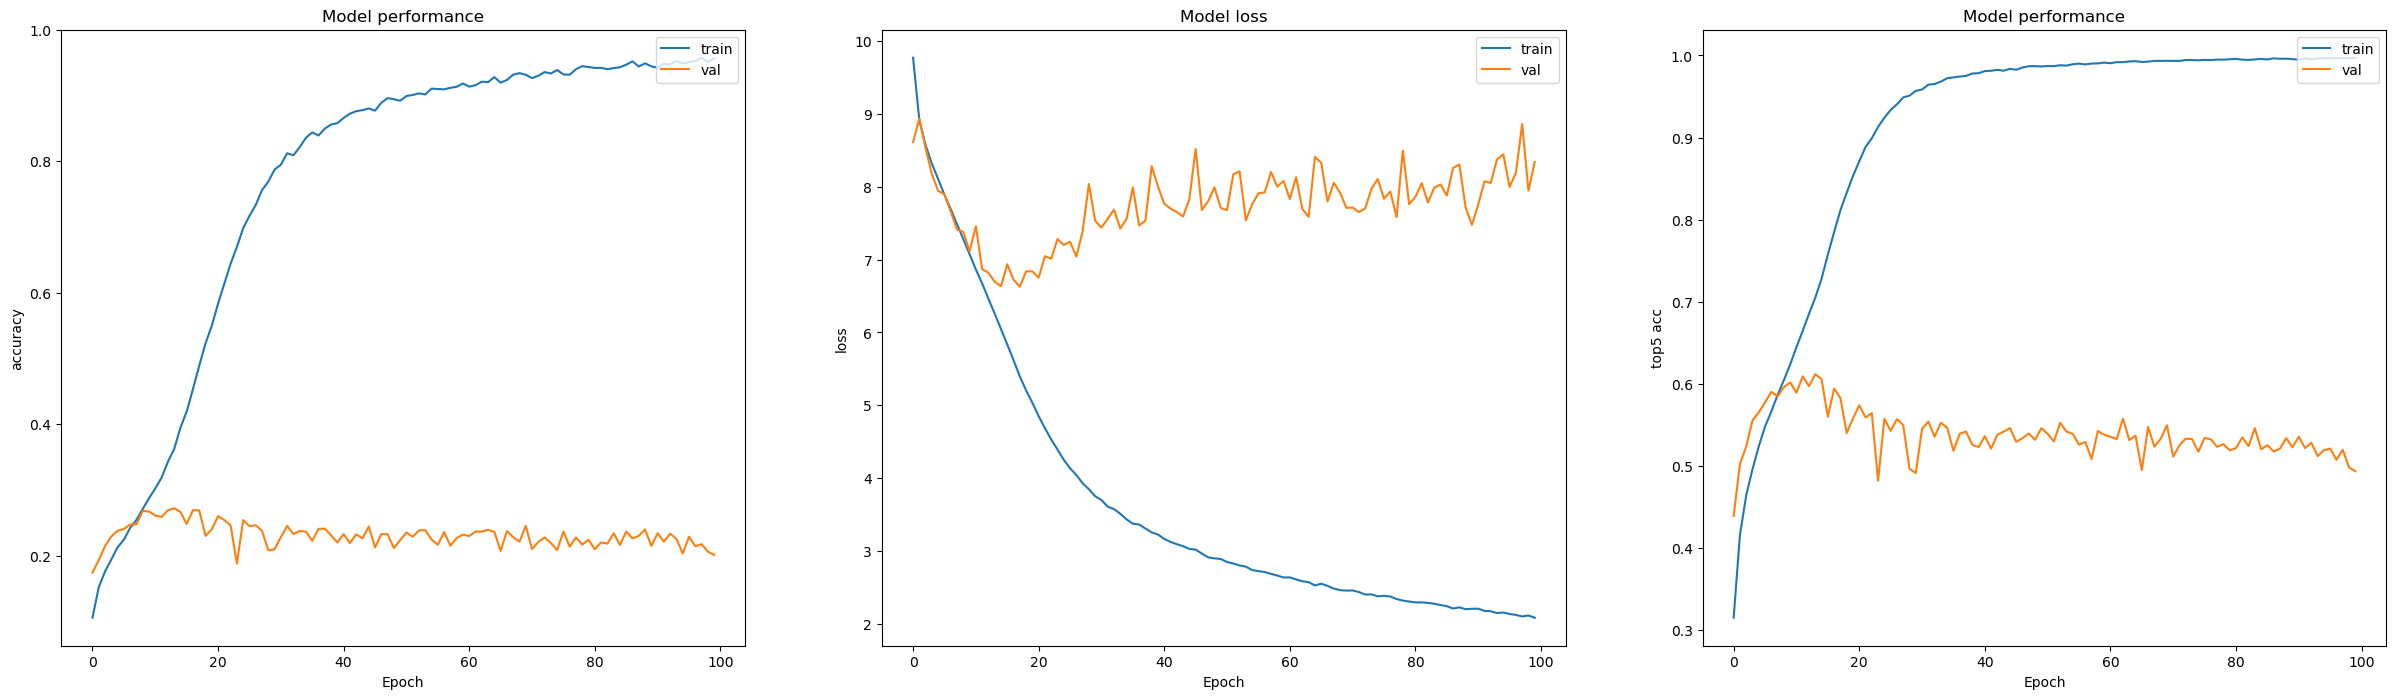

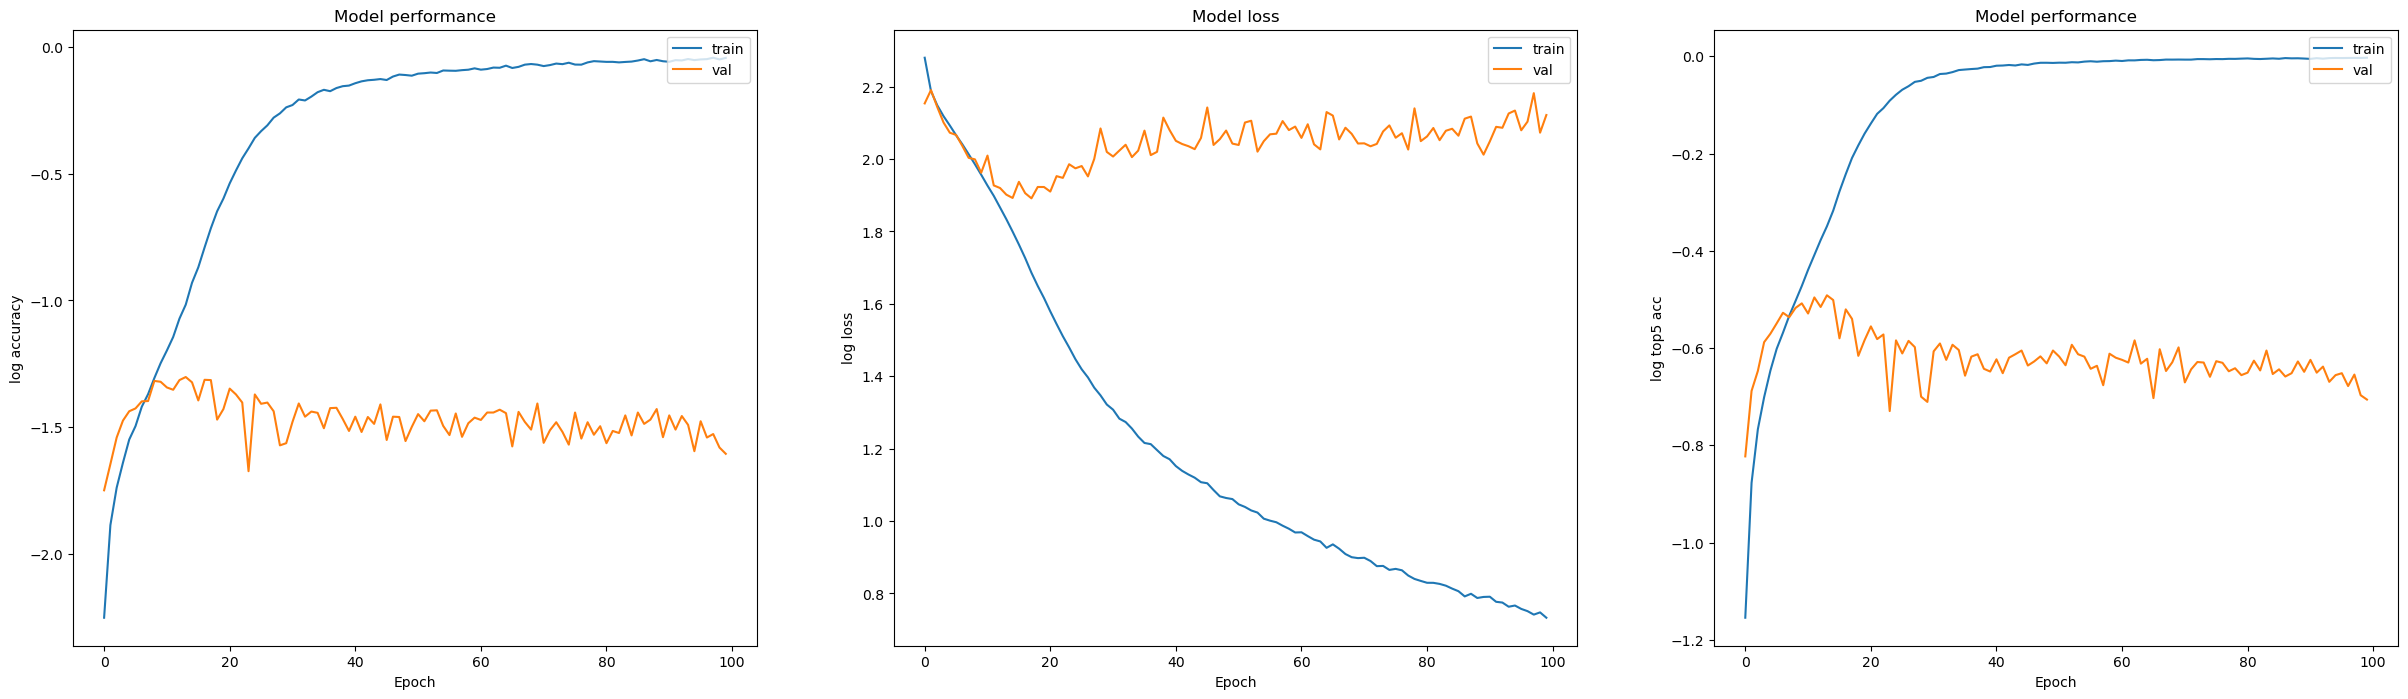

3379/3379 [==============================] - 7s 2ms/step
[8.343412588107652, 0.20094703137874603, 0.49363717436790466]


In [19]:
history = model_aug4.fit(X4_train, Y4_train, epochs = 100, batch_size = 64, validation_data=(X4_dev, Y4_dev))
model_aug4.save('model3d')
plot_learning_curves(history, False)
plot_learning_curves(history, True)
print(model_aug4.evaluate(X4_dev, Y4_dev))

#model_temp = keras.models.load_model('model_genre1e')
#print(model.evaluate(X4_dev, Y4_dev))

## 4 Arg 16

In [5]:
X16_orig = np.load('train_data_arg16.npy')
Y16_orig = to_categorical(np.load('train_labels_arg16.npy'))

In [6]:
X16_train, Y16_train, X16_test, Y16_test, X16_dev, Y16_dev = data_preprocess(X16_orig, Y16_orig)

X_train shape: (108108, 64, 64, 3)
Y_train shape: (108108, 50)
X_test shape: (13514, 64, 64, 3)
Y_test shape: (13514, 50)
X_dev shape: (13514, 64, 64, 3)
Y_dev shape: (13514, 50)


## 4.a MobileNet

In [7]:
## model 
img_height,img_width = 64, 64 
num_classes = 50 # 50 artists 
#If imagenet weights are being loaded, 
#input must have a static square shape (one of (128, 128), (160, 160), (192, 192), or (224, 224))
base_model = applications.MobileNet(weights= None, include_top=False, input_shape= (img_height,img_width,3))

In [8]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(num_classes, activation= 'softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)

In [9]:
# sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
adam = Adam(lr=0.0001)
top5_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=5)
top5_acc.__name__ = 'top5_acc'
model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['categorical_accuracy', top5_acc])

Train on 108108 samples, validate on 13514 samples
Epoch 1/100
108108/108108 [==============================] - 103s 954us/step - loss: 3.7242 - categorical_accuracy: 0.0990 - top5_acc: 0.3220 - val_loss: 3.3731 - val_categorical_accuracy: 0.1410 - val_top5_acc: 0.4140
Epoch 2/100
108108/108108 [==============================] - 91s 846us/step - loss: 3.4314 - categorical_accuracy: 0.1322 - top5_acc: 0.4024 - val_loss: 3.2920 - val_categorical_accuracy: 0.1552 - val_top5_acc: 0.4338
Epoch 3/100
108108/108108 [==============================] - 92s 848us/step - loss: 3.3282 - categorical_accuracy: 0.1478 - top5_acc: 0.4315 - val_loss: 3.2056 - val_categorical_accuracy: 0.1693 - val_top5_acc: 0.4613
Epoch 4/100
108108/108108 [==============================] - 92s 851us/step - loss: 3.2298 - categorical_accuracy: 0.1672 - top5_acc: 0.4593 - val_loss: 3.1274 - val_categorical_accuracy: 0.1823 - val_top5_acc: 0.4868
Epoch 5/100
108108/108108 [==============================] - 92s 855us/step 

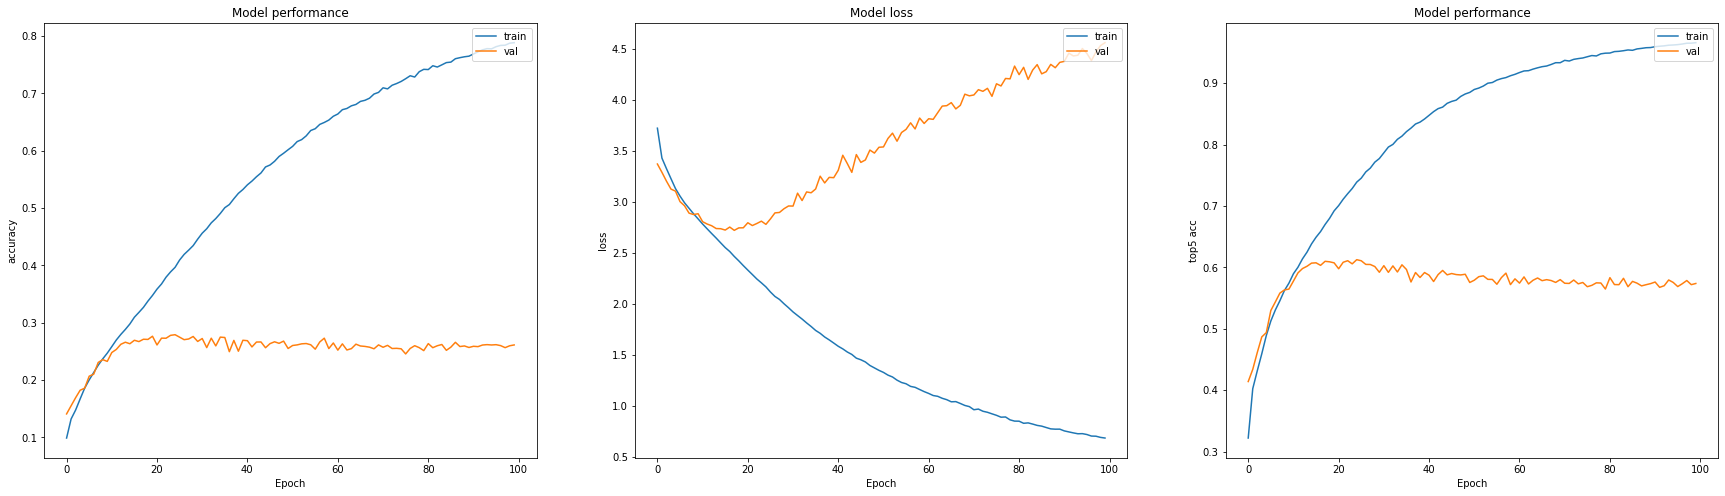

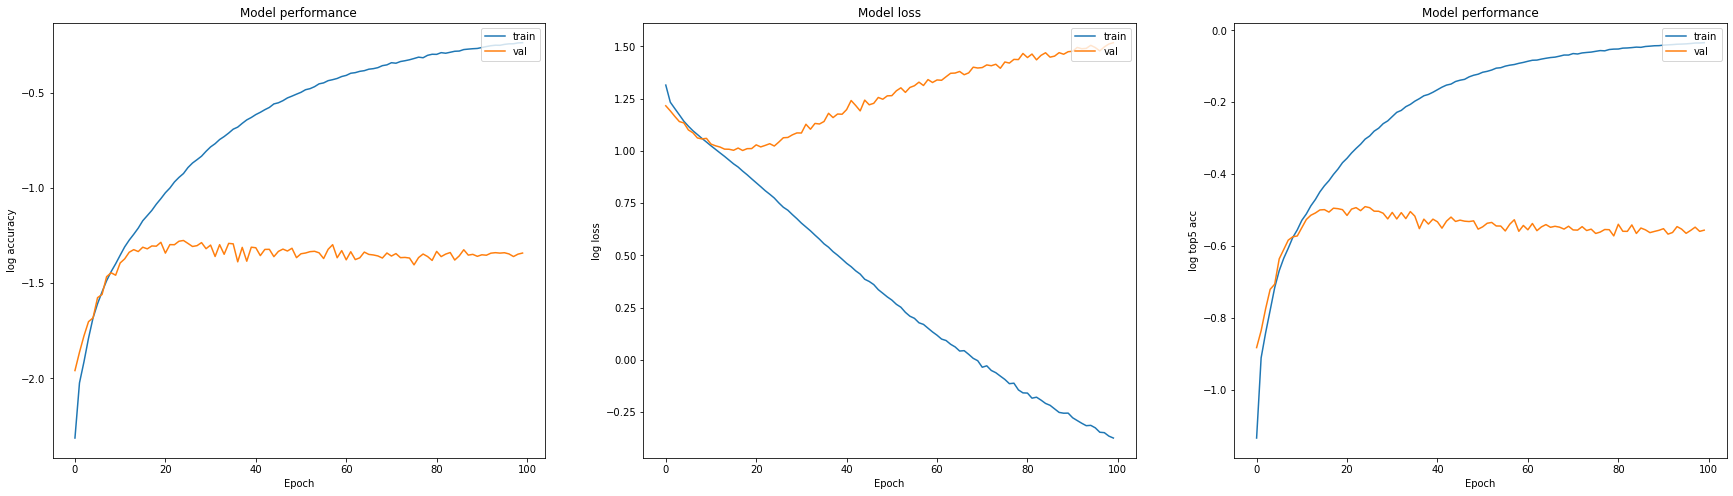

13514/13514 [==============================] - 4s 263us/step
[4.56234278607619, 0.2613585889339447, 0.5737753510475159]


In [10]:
history = model.fit(X16_train, Y16_train, epochs = 100, batch_size = 64, validation_data=(X16_dev, Y16_dev))
model.save('model4a')
plot_learning_curves(history, False)
plot_learning_curves(history, True)

#model_temp = keras.models.load_model('model_genre1e')
print(model.evaluate(X16_dev, Y16_dev))

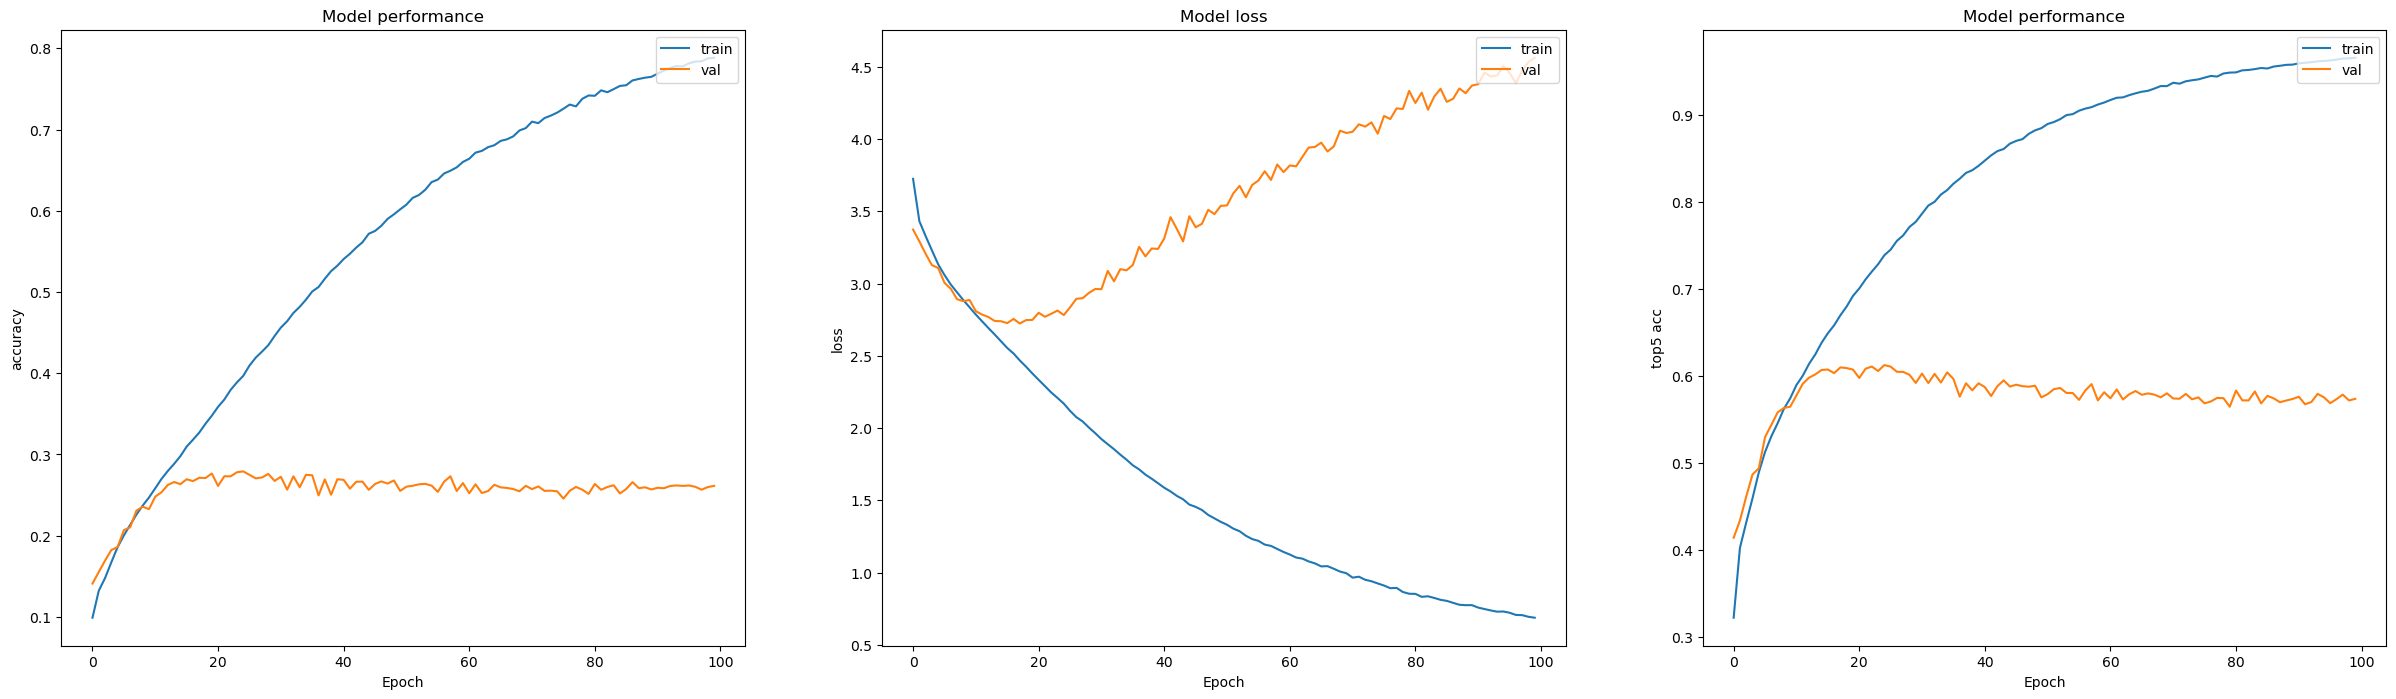

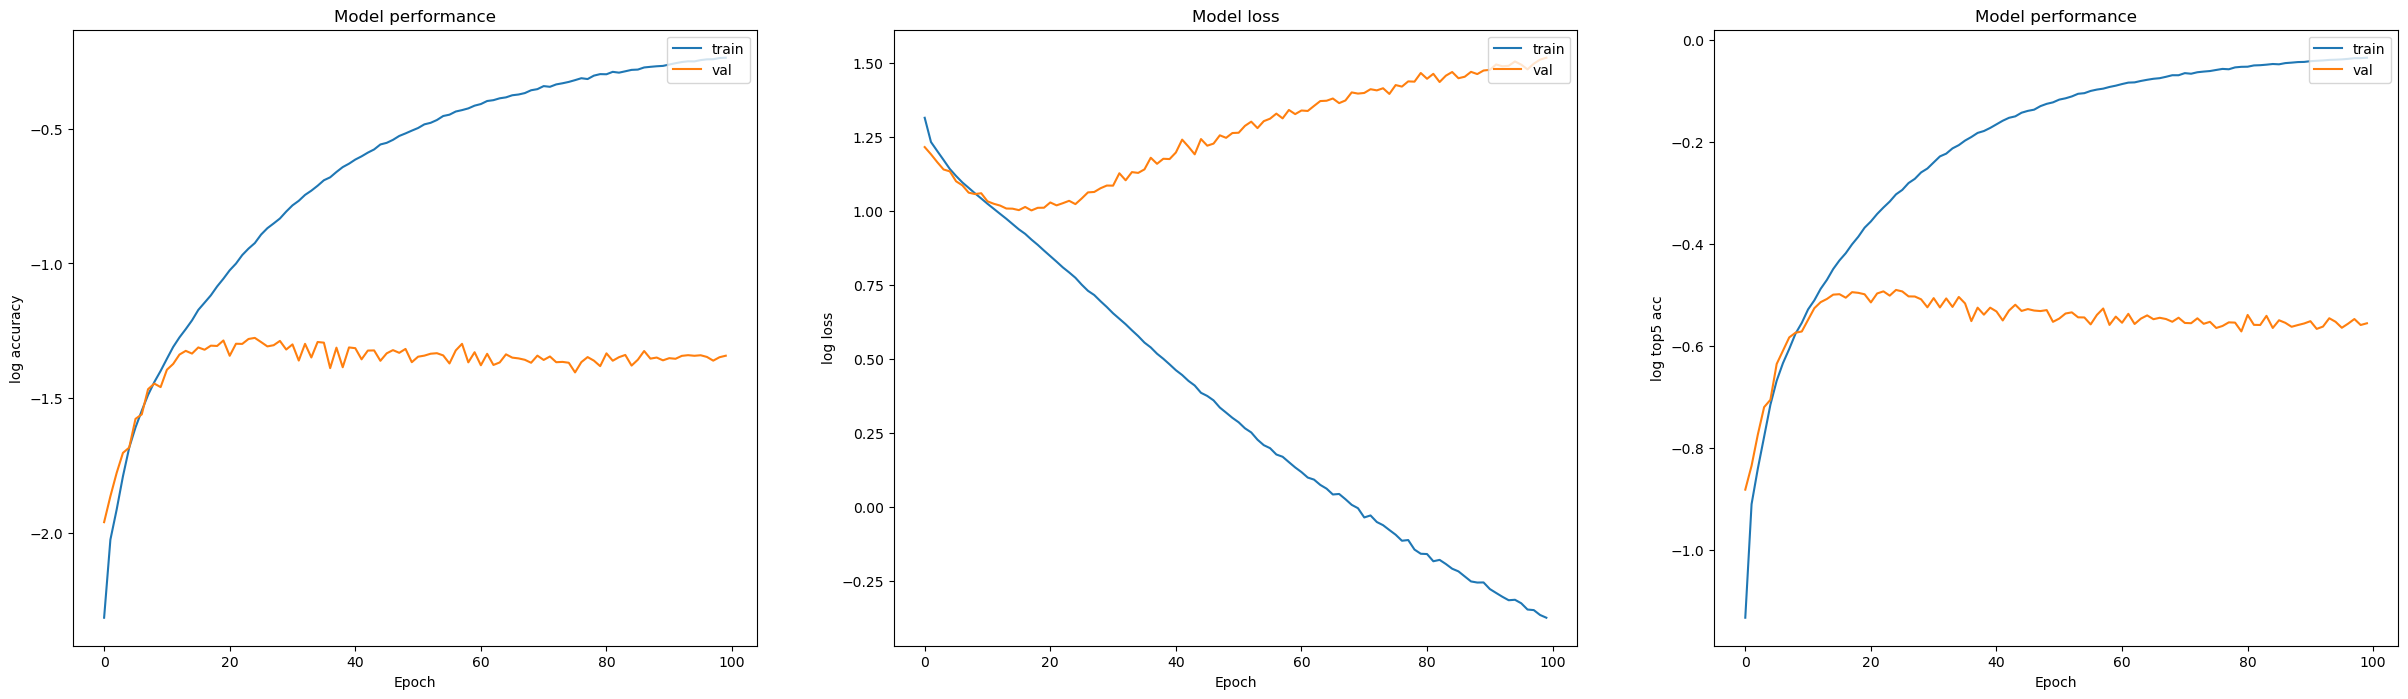

In [12]:
plot_learning_curves(history, False)
plot_learning_curves(history, True)


## 4.b ResNet50

In [7]:
## model 
img_height,img_width = 64, 64 
num_classes = 50 # 50 artists 
#If imagenet weights are being loaded, 
#input must have a static square shape (one of (128, 128), (160, 160), (192, 192), or (224, 224))
base_model = applications.resnet50.ResNet50(weights= None, include_top=False, input_shape= (img_height,img_width,3))

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [8]:
l2_model = add_regularization(base_model, regularizer=keras.regularizers.l2(0.0001))
x = l2_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.9)(x)
predictions = Dense(num_classes, activation= 'softmax')(x)
model = Model(inputs = l2_model.input, outputs = predictions)


In [9]:
# sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
adam = Adam(lr=0.0001)
top5_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=5)
top5_acc.__name__ = 'top5_acc'
model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['categorical_accuracy', top5_acc])

Train on 108108 samples, validate on 13514 samples
Epoch 1/100
108108/108108 [==============================] - 277s 3ms/step - loss: 10.2127 - categorical_accuracy: 0.0926 - top5_acc: 0.2995 - val_loss: 12.3043 - val_categorical_accuracy: 0.1573 - val_top5_acc: 0.4305
Epoch 2/100
108108/108108 [==============================] - 252s 2ms/step - loss: 8.9844 - categorical_accuracy: 0.1348 - top5_acc: 0.3868 - val_loss: 8.5238 - val_categorical_accuracy: 0.1722 - val_top5_acc: 0.4576
Epoch 3/100
108108/108108 [==============================] - 252s 2ms/step - loss: 8.3422 - categorical_accuracy: 0.1542 - top5_acc: 0.4243 - val_loss: 9.4344 - val_categorical_accuracy: 0.1806 - val_top5_acc: 0.4751
Epoch 4/100
108108/108108 [==============================] - 252s 2ms/step - loss: 7.6433 - categorical_accuracy: 0.1734 - top5_acc: 0.4571 - val_loss: 8.9691 - val_categorical_accuracy: 0.2048 - val_top5_acc: 0.5092
Epoch 5/100
108108/108108 [==============================] - 252s 2ms/step - lo

KeyError: 'accuracy'

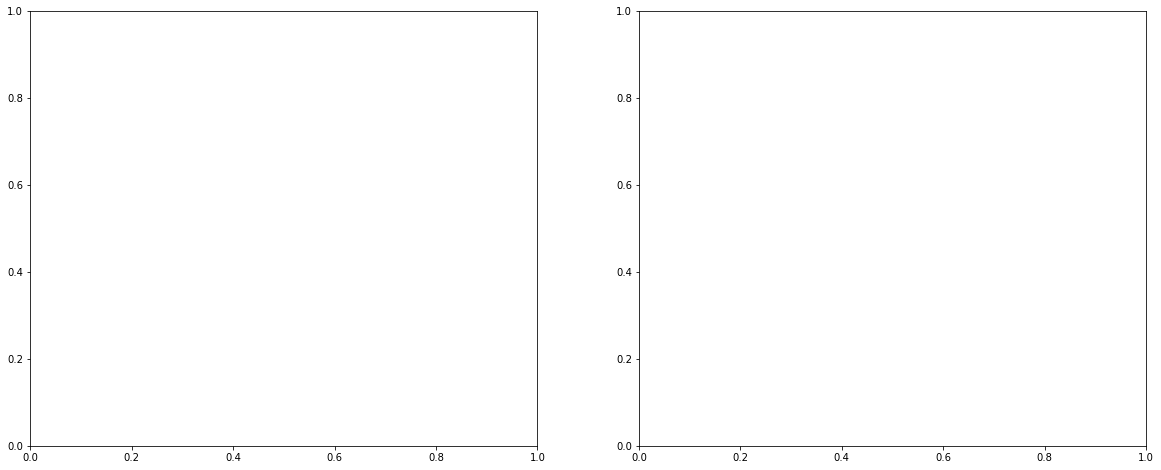

In [10]:
history = model.fit(X16_train, Y16_train, epochs = 100, batch_size = 64, validation_data=(X16_dev, Y16_dev))
model.save('model4b')
plot_learning_curves(history, False)
plot_learning_curves(history, True)

#model_temp = keras.models.load_model('model_genre1e')
print(model.evaluate(X16_dev, Y16_dev))

In [13]:
print(model.evaluate(X16_dev, Y16_dev))

13514/13514 [==============================] - 10s 750us/step
[4.726282007969112, 0.31574663519859314, 0.6402249336242676]


In [11]:
print(history.history.keys())

dict_keys(['val_loss', 'val_categorical_accuracy', 'val_top5_acc', 'loss', 'categorical_accuracy', 'top5_acc'])


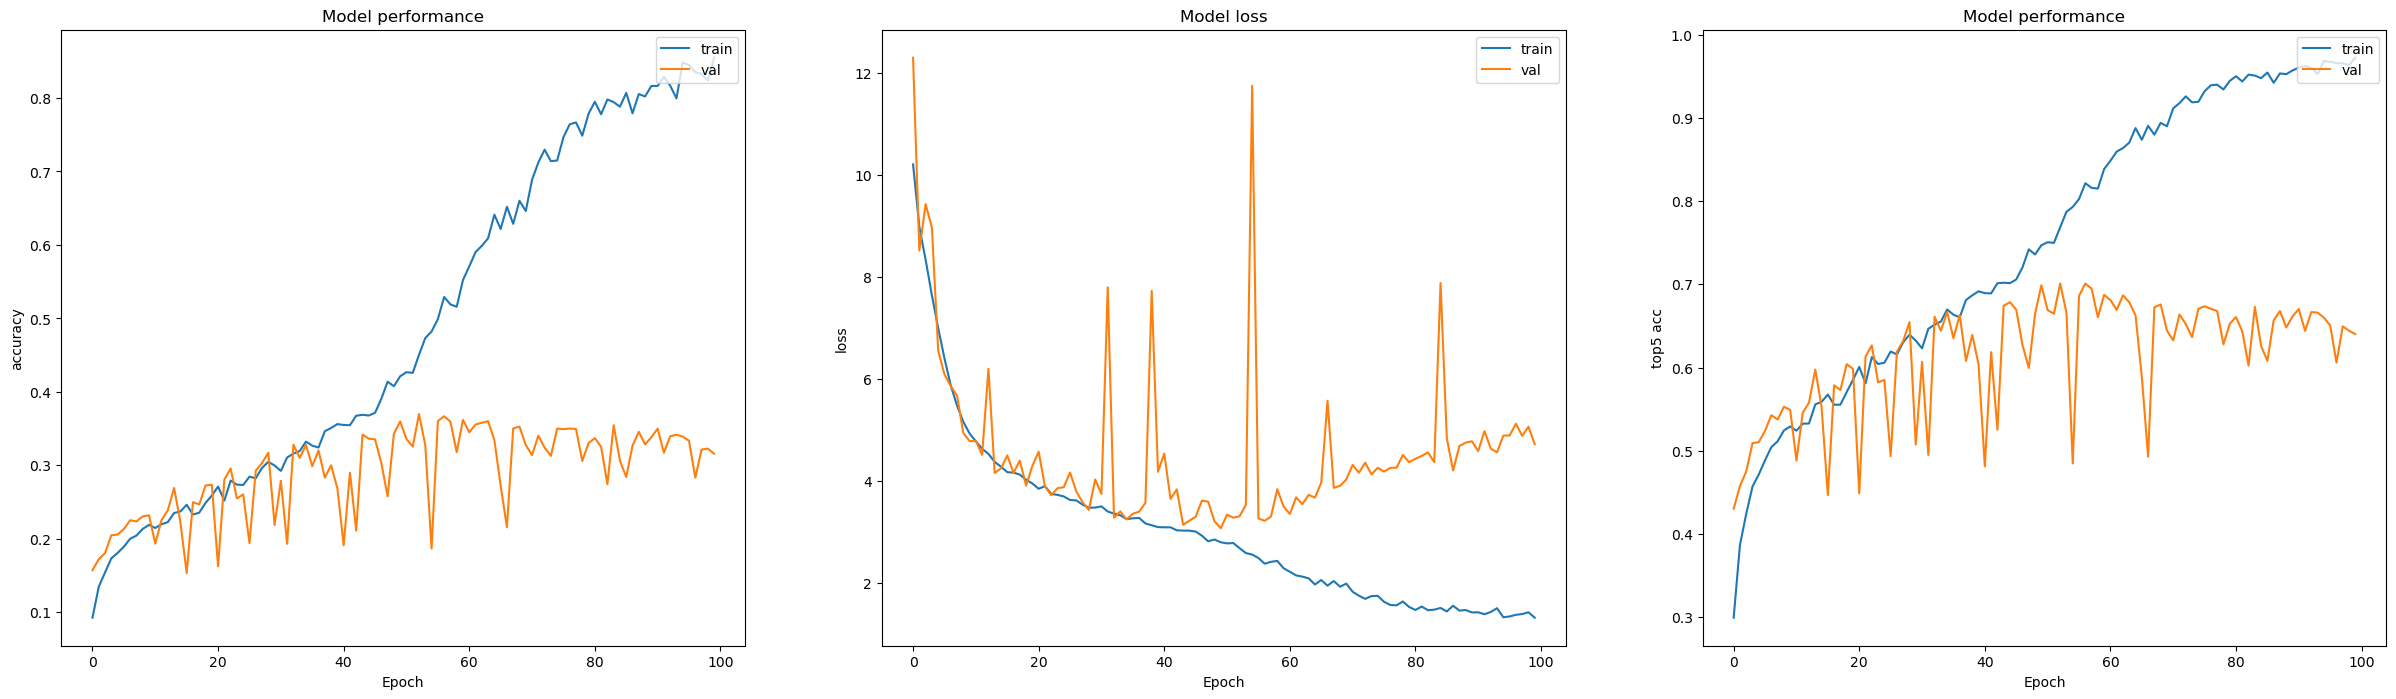

In [20]:
plot_learning_curves(history, False)

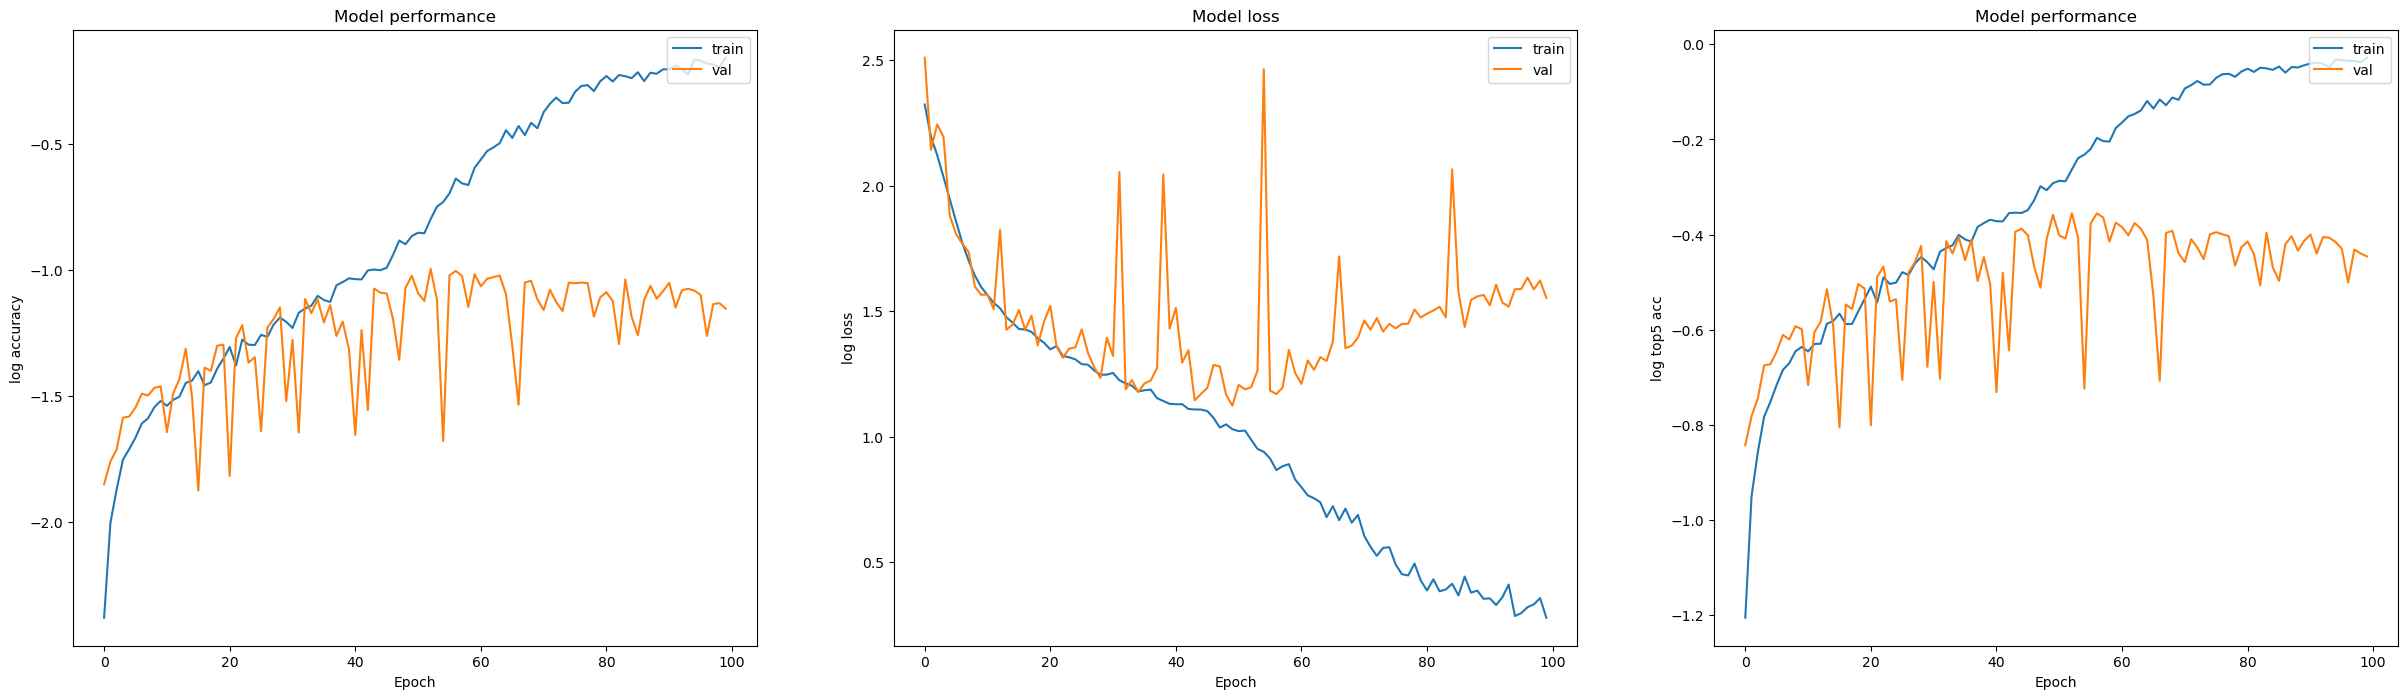

In [21]:
plot_learning_curves(history, True)

## 4c MobileNet

In [23]:
## model 
img_height,img_width = 64, 64 
num_classes = 50 # 50 artists 
#If imagenet weights are being loaded, 
#input must have a static square shape (one of (128, 128), (160, 160), (192, 192), or (224, 224))
base_model = applications.MobileNet(weights= None, include_top=False, input_shape= (img_height,img_width,3))

In [24]:
l2_model = add_regularization(base_model, regularizer=keras.regularizers.l2(0.0001))
x = l2_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.9)(x)
predictions = Dense(num_classes, activation= 'softmax')(x)
model = Model(inputs = l2_model.input, outputs = predictions)

In [25]:
# sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
adam = Adam(lr=0.0001)
top5_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=5)
top5_acc.__name__ = 'top5_acc'
model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['categorical_accuracy', top5_acc])

Train on 108108 samples, validate on 13514 samples
Epoch 1/100
108108/108108 [==============================] - 101s 930us/step - loss: 4.7099 - categorical_accuracy: 0.0746 - top5_acc: 0.2543 - val_loss: 3.9975 - val_categorical_accuracy: 0.1357 - val_top5_acc: 0.3906
Epoch 2/100
108108/108108 [==============================] - 94s 867us/step - loss: 4.1057 - categorical_accuracy: 0.1182 - top5_acc: 0.3551 - val_loss: 3.9083 - val_categorical_accuracy: 0.1482 - val_top5_acc: 0.4144
Epoch 3/100
108108/108108 [==============================] - 93s 864us/step - loss: 3.9696 - categorical_accuracy: 0.1336 - top5_acc: 0.3978 - val_loss: 3.8073 - val_categorical_accuracy: 0.1585 - val_top5_acc: 0.4352
Epoch 4/100
108108/108108 [==============================] - 93s 861us/step - loss: 3.8614 - categorical_accuracy: 0.1492 - top5_acc: 0.4230 - val_loss: 3.7051 - val_categorical_accuracy: 0.1734 - val_top5_acc: 0.4580
Epoch 5/100
108108/108108 [==============================] - 93s 864us/step 

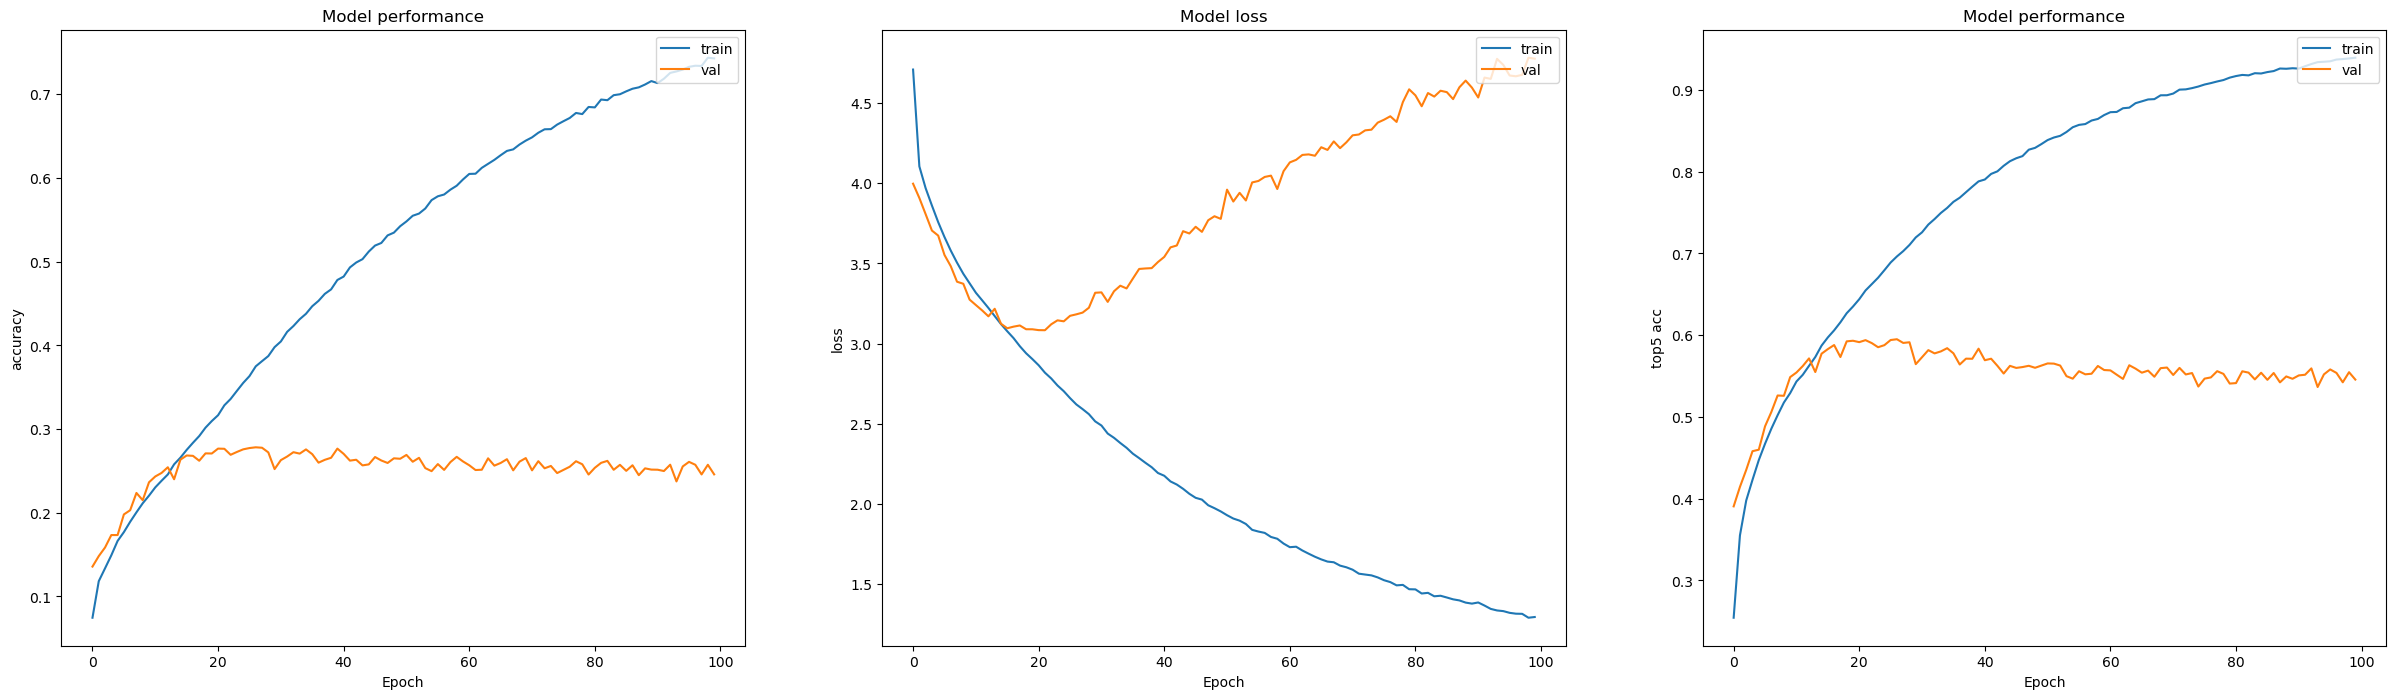

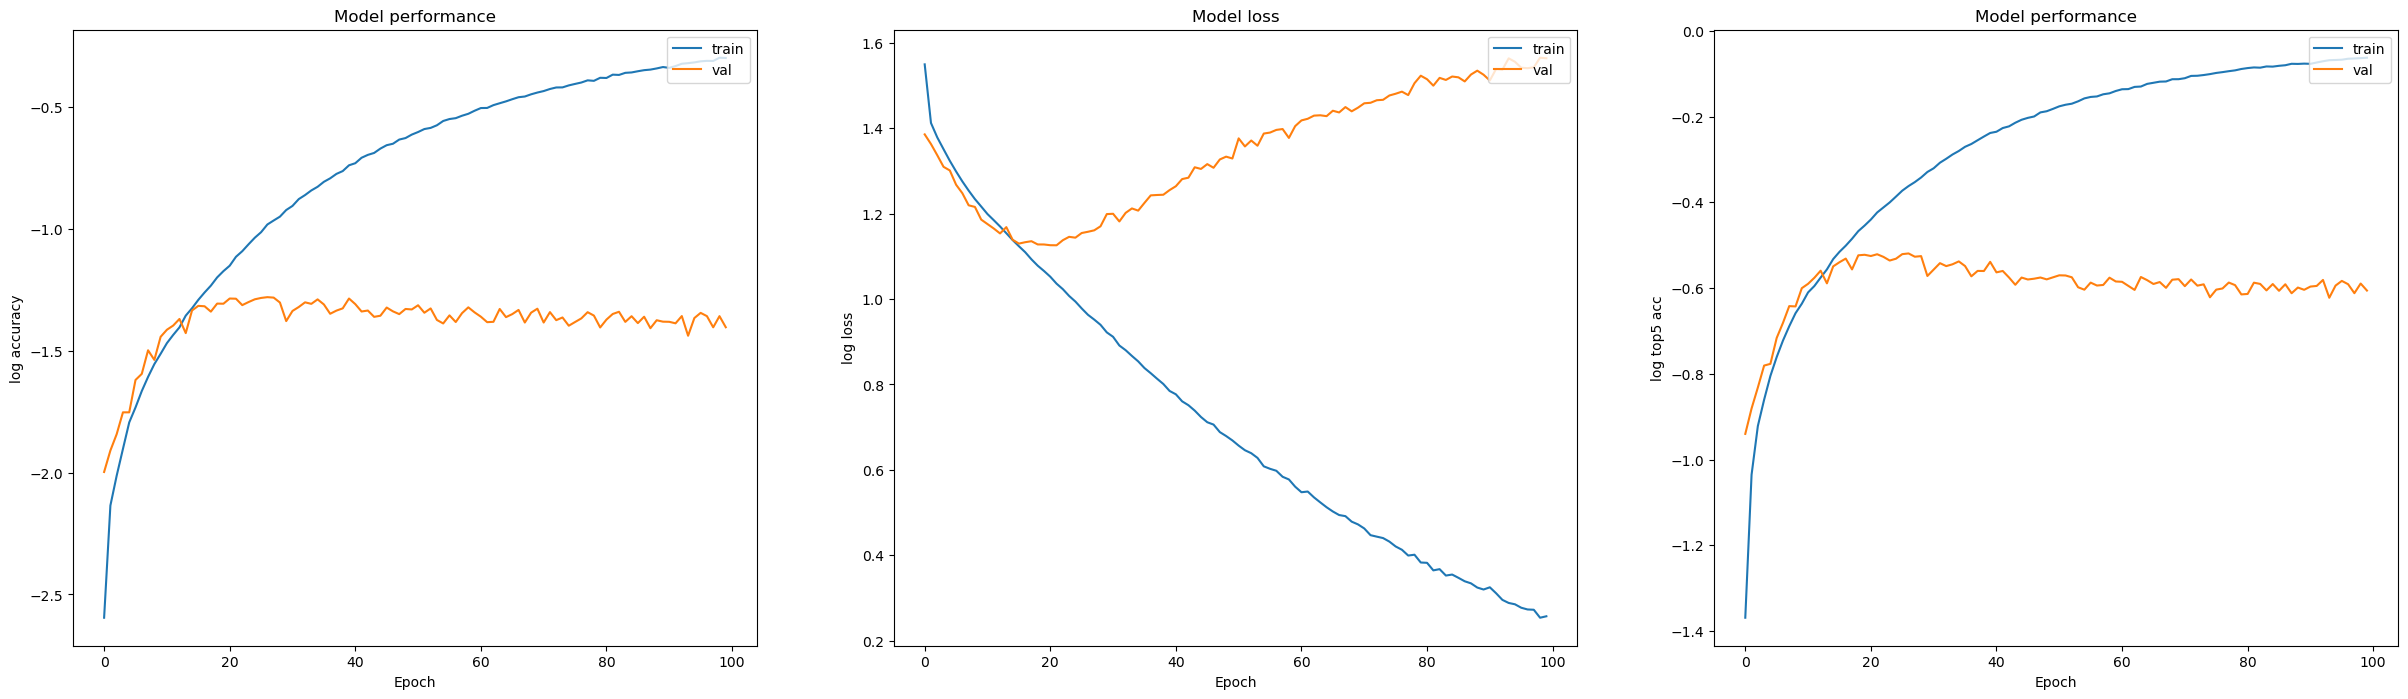

13514/13514 [==============================] - 4s 308us/step
[4.777640534167073, 0.24589315056800842, 0.5456563830375671]


In [26]:
history = model.fit(X16_train, Y16_train, epochs = 100, batch_size = 64, validation_data=(X16_dev, Y16_dev))
model.save('model4c')
plot_learning_curves(history, False)
plot_learning_curves(history, True)

#model_temp = keras.models.load_model('model_genre1e')
print(model.evaluate(X16_dev, Y16_dev))

## 4d MobileNet

In [27]:
## model 
img_height,img_width = 64, 64 
num_classes = 50 # 50 artists 
#If imagenet weights are being loaded, 
#input must have a static square shape (one of (128, 128), (160, 160), (192, 192), or (224, 224))
base_model = applications.MobileNet(weights= None, include_top=False, input_shape= (img_height,img_width,3))

In [28]:
l2_model = add_regularization(base_model, regularizer=keras.regularizers.l2(0.001))
x = l2_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(num_classes, activation= 'softmax')(x)
model = Model(inputs = l2_model.input, outputs = predictions)

In [29]:
# sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
adam = Adam(lr=0.0001)
top5_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=5)
top5_acc.__name__ = 'top5_acc'
model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['categorical_accuracy', top5_acc])

Train on 108108 samples, validate on 13514 samples
Epoch 1/100
108108/108108 [==============================] - 99s 916us/step - loss: 8.7948 - categorical_accuracy: 0.1011 - top5_acc: 0.3147 - val_loss: 8.1349 - val_categorical_accuracy: 0.1486 - val_top5_acc: 0.4111
Epoch 2/100
108108/108108 [==============================] - 93s 862us/step - loss: 7.7750 - categorical_accuracy: 0.1374 - top5_acc: 0.4001 - val_loss: 7.1902 - val_categorical_accuracy: 0.1672 - val_top5_acc: 0.4414
Epoch 3/100
108108/108108 [==============================] - 93s 862us/step - loss: 6.7963 - categorical_accuracy: 0.1588 - top5_acc: 0.4393 - val_loss: 6.2543 - val_categorical_accuracy: 0.1791 - val_top5_acc: 0.4756
Epoch 4/100
108108/108108 [==============================] - 94s 868us/step - loss: 5.9280 - categorical_accuracy: 0.1740 - top5_acc: 0.4716 - val_loss: 5.5053 - val_categorical_accuracy: 0.1889 - val_top5_acc: 0.4952
Epoch 5/100
108108/108108 [==============================] - 94s 865us/step -

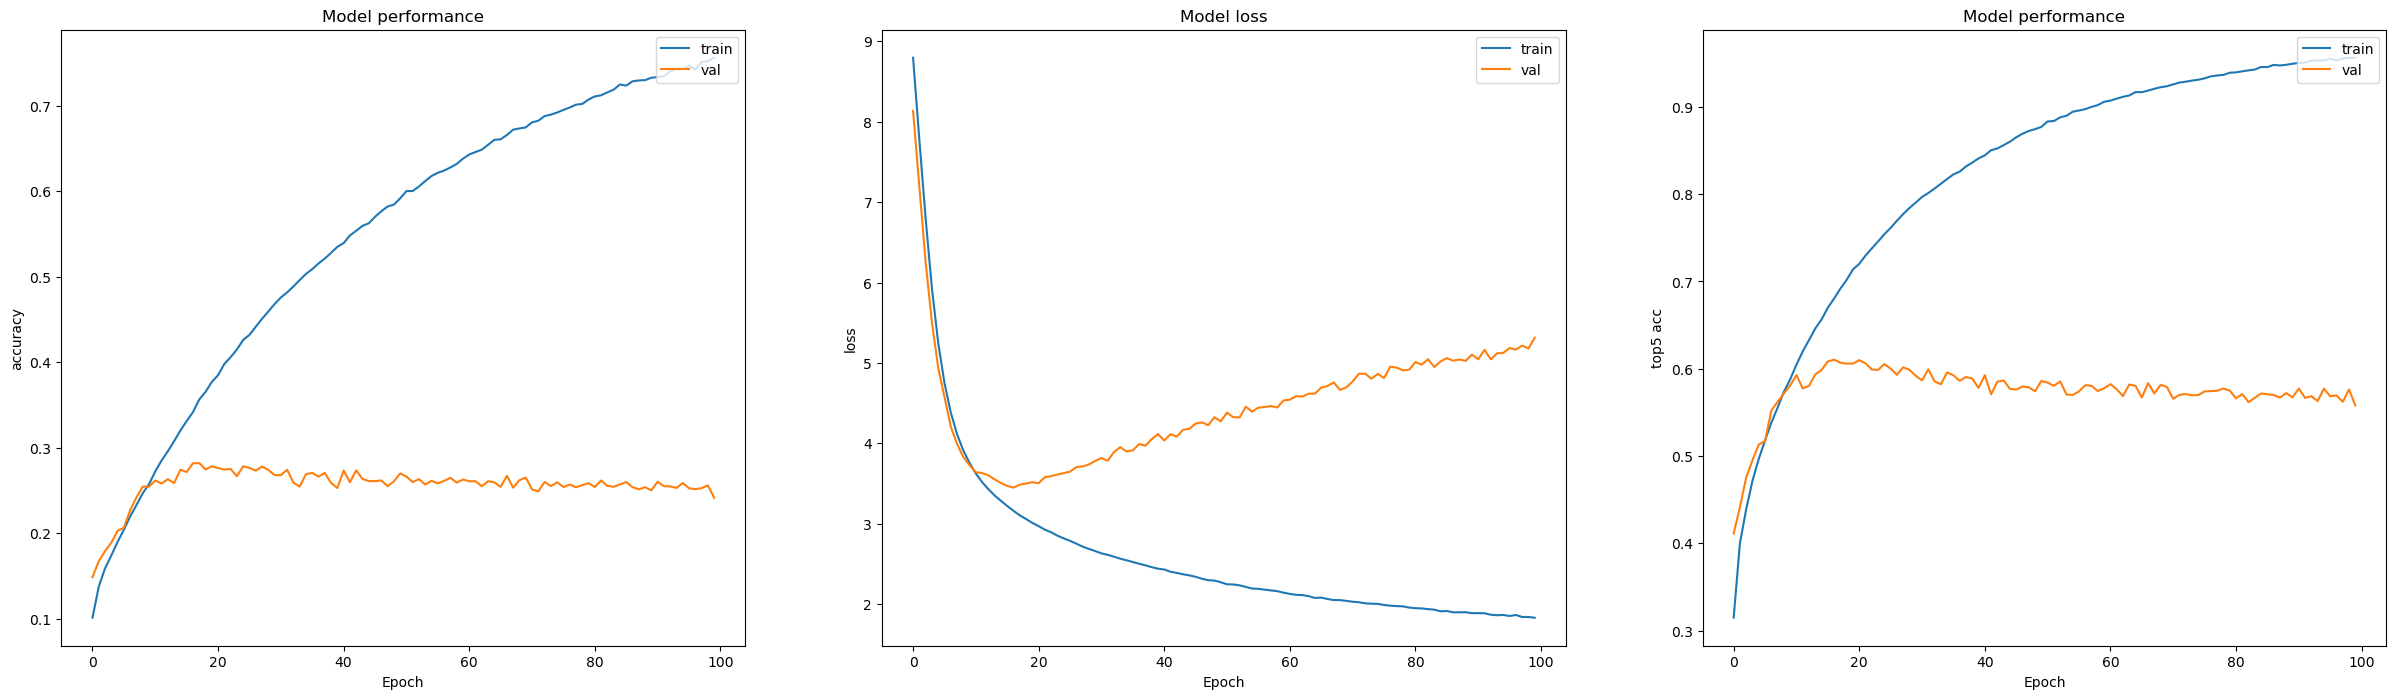

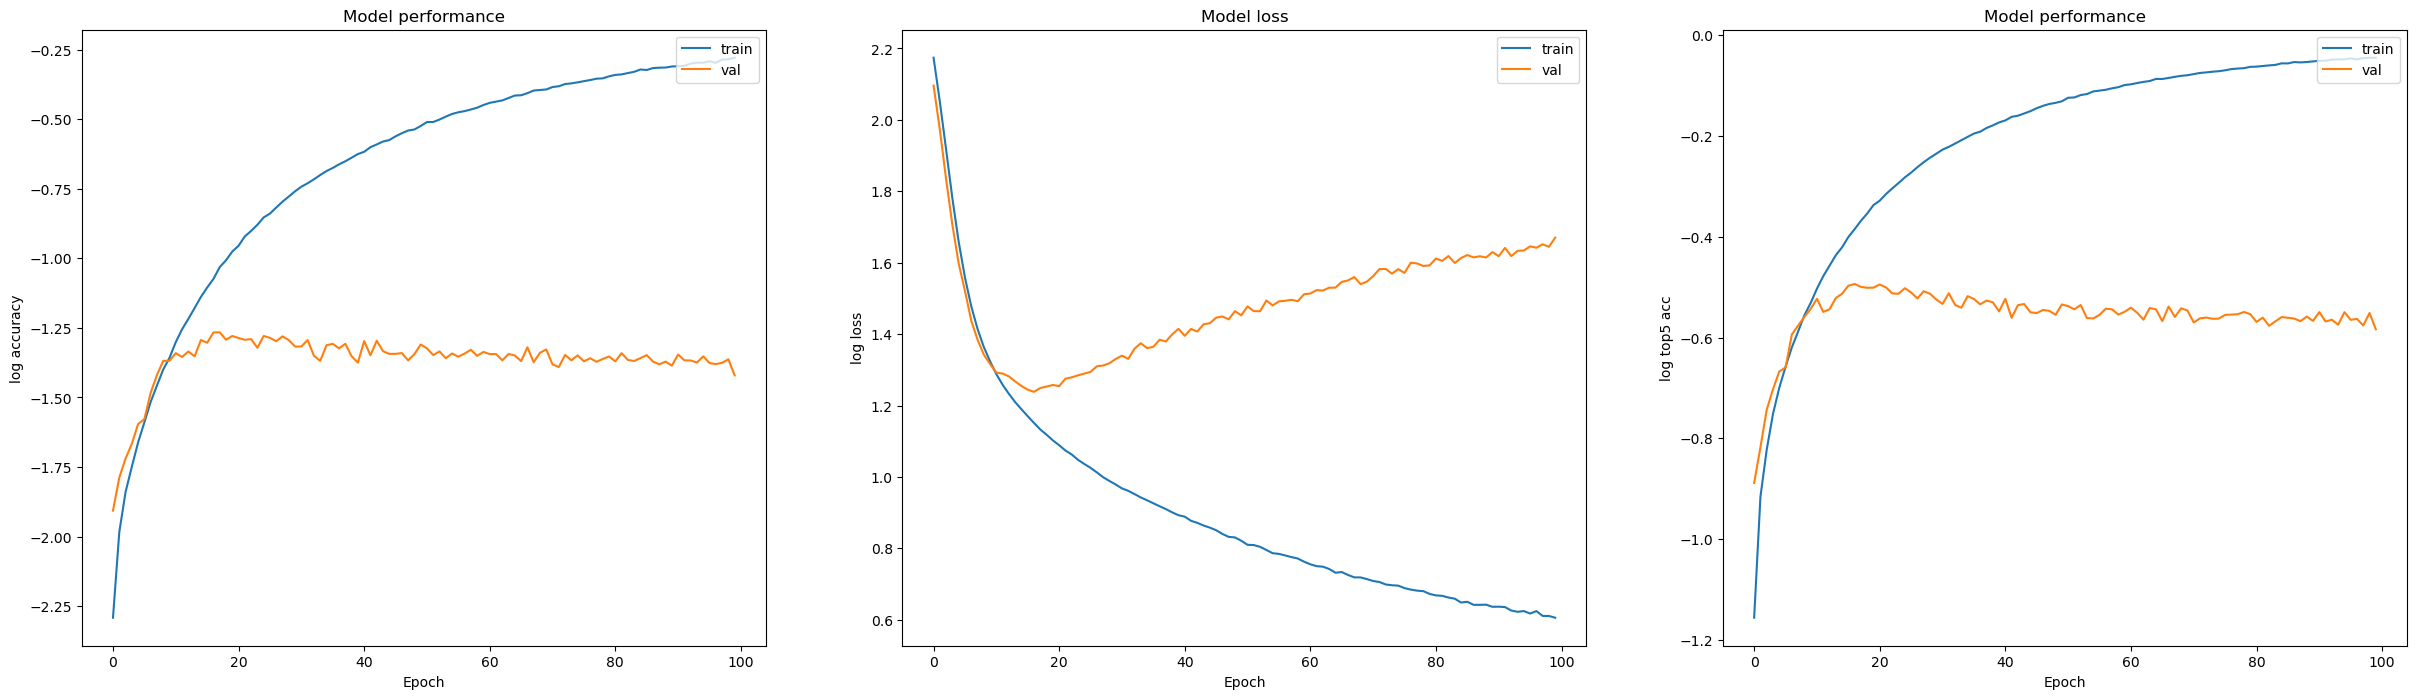

13514/13514 [==============================] - 4s 287us/step
[5.313612423829467, 0.24160130321979523, 0.5578659176826477]


In [30]:
history = model.fit(X16_train, Y16_train, epochs = 100, batch_size = 64, validation_data=(X16_dev, Y16_dev))
model.save('model4d')
plot_learning_curves(history, False)
plot_learning_curves(history, True)

#model_temp = keras.models.load_model('model_genre1e')
print(model.evaluate(X16_dev, Y16_dev))